**Please don't edit this cell!**

# Marks and Feedback

**Total Marks:**   XX/100

**Overall comments:**


## Part 1. Investigations into Neural Networks (35 marks)

* **Task 1**:   *Experiments with learning rate schedules* - XX/5
    * learning rate schedulers implemented
    * experiments carried out
    * further comments


* **Task 2**:   *Experiments with regularisation* - XX/5
    * L1 experiments
    * L2 experiments
    * dropout experiments
    * annealed dropout implmented
    * further experiments carried out
    * further comments
    

* **Task 3**:   *Experiments with pretraining* - XX/15
    * autoencoder pretraining implemented
    * denoising autoencoder pretraining implemented
    * CE layer-by-layer pretraining implemented
    * experiments
    * further comments


* **Task 4**:   *Experiments with data augmentation* - XX/5
    * training data augmneted using noise, rotation, ...
    * any further augmnetations
    * experiments 
    * further comments


* **Task 5**:   *State of the art* - XX/5
    * motivation for systems constructed
    * experiments
    * accuracy of best system
    * further comments



## Part 2. Convolutional Neural Networks (55 marks)

* **Task 6**:   *Implement convolutional layer* - XX/20
    * linear conv layer
    * sigmoid conv layer
    * relu conv layer
    * any checks for correctness
    * loop-based or vectorised implementations
    * timing comparisons


* **Task 7**:   *Implement maxpooling layer* - XX/10
    * implementation of non-overlapping pooling
    * generic implementation
    * any checks for correctness


* **Task 8**:   *Experiments with convolutional networks* - XX/25
    * 1 conv layer (1 fmap)
    * 1 conv layer (5 fmaps)
    * 2 conv layers
    * further experiments



## Presentation (10 marks)

* ** Marks:**   XX/10
    * Concise description of each system constructed
    * Experiment design and motivations for different systems
    * Presentation of results - graphs, tables, diagrams
    * Conclusions



# Coursework #2

## Introduction


## Previous Tutorials

Before starting this coursework make sure that you have completed the following labs:

* [04_Regularisation.ipynb](https://github.com/CSTR-Edinburgh/mlpractical/blob/master/04_Regularisation.ipynb) - regularising the model
* [05_Transfer_functions.ipynb](https://github.com/CSTR-Edinburgh/mlpractical/blob/master/05_Transfer_functions.ipynb) - building and training different activation functions
* [06_MLP_Coursework2_Introduction.ipynb](https://github.com/CSTR-Edinburgh/mlpractical/blob/master/06_MLP_Coursework2_Introduction.ipynb) - Notes on numpy and tensors


## Submission
**Submission Deadline:  Thursday 14 January 2016, 16:00** 

Submit the coursework as an ipython notebook file, using the `submit` command in the terminal on a DICE machine. If your file is `06_MLP_Coursework1.ipynb` then you would enter:

`submit mlp 2 06_MLP_Coursework1.ipynb` 

where `mlp 2` indicates this is the second coursework of MLP.

After submitting, you should receive an email of acknowledgment from the system confirming that your submission has been received successfully. Keep the email as evidence of your coursework submission.

**Please make sure you submit a single `ipynb` file (and nothing else)!**

**Submission Deadline:  Thursday 14 January 2016, 16:00** 



## Getting Started
Please enter your student number and the date in the next code cell.

In [ ]:
#MLP Coursework 2
#Student number: B035680 (s1232123)
#Date: 01.01.2016

In [2]:
import numpy
import logging
import time
import matplotlib.pyplot as plt

from mlp.layers import MLP, Linear, Sigmoid, Softmax #import required layer types
from mlp.optimisers import SGDOptimiser, CrossEntropyOptimiser, AutoEncoderOptimiser#import the optimiser
from mlp.dataset import MNISTDataProvider #import data provider
from mlp.costs import CECost #import the cost we want to use for optimisation
from mlp.schedulers import LearningRateFixed, LearningRateNewBob, LearningRateExponential, LearningRateReciprocal
from mlp.schedulers import DropoutFixed, DropoutAnnealing
from mlp.noise import Augmenter, DropOutNoise, DropOutRotation
from mlp.conv import ConvSigmoid, ConvMaxPool2D
rng = numpy.random.RandomState([2015,10,10])
rng_state = rng.get_state()
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

logger.warning("Initialising Data Providers...")
train_dp = MNISTDataProvider(dset='train', batch_size=100, max_num_batches=-10, randomize=True)
valid_dp = MNISTDataProvider(dset='valid', batch_size=10000, max_num_batches=-10, randomize=False)
test_dp = MNISTDataProvider(dset='eval', batch_size=10000, max_num_batches=-10, randomize=False)
logger.warning("Data Providers Initialised")


# Part 1. Investigations into Neural Networks (35 marks)

In this part you are may choose exactly what you implement. However, you are expected to express your motivations, observations, and findings in a clear and cohesive way. Try to make it clear why you decided to do certain things. Use graphs and/or tables of results to show trends and other characteristics you think are important. 

For example, in Task 1 you could experiment with different schedulers in order to compare their convergence properties. In Task 2 you could look into (and visualise) what happens to weights when applying L1 and/or L2 regularisation when training. For instance, you could create sorted histograms of weight magnitudes in in each layer, etc..

**Before submission, please collapse all the log entries into smaller boxes (by clicking on the bar on the left hand side)**

### Task 1 - Experiments with learning rate schedules (5 marks)

Investigate the effect of learning rate schedules on training and accuracy.  Implement at least one additional learning rate scheduler mentioned in the lectures. 

In [ ]:
#load the corresponding code here, and also attach scripts that run the experiments ()

class LearningRateExponential(LearningRateList):
    def __init__(self, learning_rate, max_epochs, r):
        assert learning_rate > 0, (
            "learning rate expected to be > 0, got %f" % learning_rate
        )
        self.r = r
        super(LearningRateExponential, self).__init__([learning_rate], max_epochs)

    def get_rate(self):
        if self.epoch < self.max_epochs:
            rate = self.lr_list[0] * np.exp(- float(self.epoch) / float(self.r))
            return rate
        return 0.0

    def get_next_rate(self, current_accuracy=None):
        super(LearningRateExponential, self).get_next_rate(current_accuracy=None)
        # logger.warning("Exponential Rate: " + str(self.get_rate()))
        return self.get_rate()


class LearningRateReciprocal(LearningRateList):

    def __init__(self, learning_rate, max_epochs, r, c):
        assert learning_rate > 0, (
            "learning rate expected to be > 0, got %f" % learning_rate
        )
        self.r = r
        self.c = c
        super(LearningRateReciprocal, self).__init__([learning_rate], max_epochs)

    def get_rate(self):
        if self.epoch < self.max_epochs:
            rate = self.lr_list[0] * np.power(1.0 + (float(self.epoch) / float(self.r)), - float(self.c))
            return rate
        return 0.0

    def get_next_rate(self, current_accuracy=None):
        super(LearningRateReciprocal, self).get_next_rate(current_accuracy=None)
        # logger.warning("Reciprocal Rate: " + str(self.get_rate()))
        return self.get_rate()

In [7]:
"""
Testing different learning rates with different values in an effort to see which value gives the best result.
"""

nhid = 100
learning_rates = [1.0,0.5,0.25,0.1]
labels = ["Fixed Rate", "NewBob Rate", "Exponential Rate", "Reciprocal Rate"]
max_epochs = 20
l1_weight = 0.0
l2_weight = 0.0
label = ""
cost = CECost()
stats = []    
layer = 1
logger.setLevel(logging.WARNING)

for learning_rate in learning_rates:
    learning_rate_results = []
    for i in xrange(1, 5):

        train_dp.reset()
        valid_dp.reset()
        test_dp.reset()

        #define the model
        model = MLP(cost=cost)
        model.add_layer(Sigmoid(idim=784, odim=nhid, irange=0.2, rng=rng))

        for x in xrange(1, layer):
            logger.info("Stacking hidden layer (%s)" % str(x+1))
            model.add_layer(Sigmoid(idim=nhid, odim=nhid, irange=0.2, rng=rng))

        model.add_layer(Softmax(idim=nhid, odim=10, rng=rng))

        # define the optimiser, here stochasitc gradient descent
        # with fixed learning rate and max_epochs

        if i == 1:
            lr_scheduler = LearningRateFixed(learning_rate=learning_rate/2.0, max_epochs=max_epochs)
        elif i == 2:
            lr_scheduler = LearningRateNewBob(start_rate=learning_rate)
        elif i == 3:
            # r is set to 20, which gives a nice exponential curve based on training set 
            lr_scheduler = LearningRateExponential(learning_rate=learning_rate, max_epochs=max_epochs, r=20.0)
        elif i == 4:
            label = "Reciprocal Rate"
            lr_scheduler = LearningRateReciprocal(learning_rate=learning_rate, max_epochs=max_epochs, r=20.0, c=1.0)

        optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, 
                                 dp_scheduler=None,
                                 l1_weight=l1_weight, 
                                 l2_weight=l2_weight)

        logger.warning('Training started for {0} at starting rate {1}'.format(labels[i-1], learning_rate))

        start_time = time.clock()
        tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)    
        end_time = time.clock()
        logger.warning('Time taken to train: {0}'.format(end_time - start_time))

        logger.warning('Testing the model on test set:')
        tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
        logger.warning('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))

        learning_rate_results.append((tr_stats, valid_stats, (tst_cost, tst_accuracy)))
        
    stats.append(learning_rate_results)
    
logger.warning('Model Testing Complete.')        





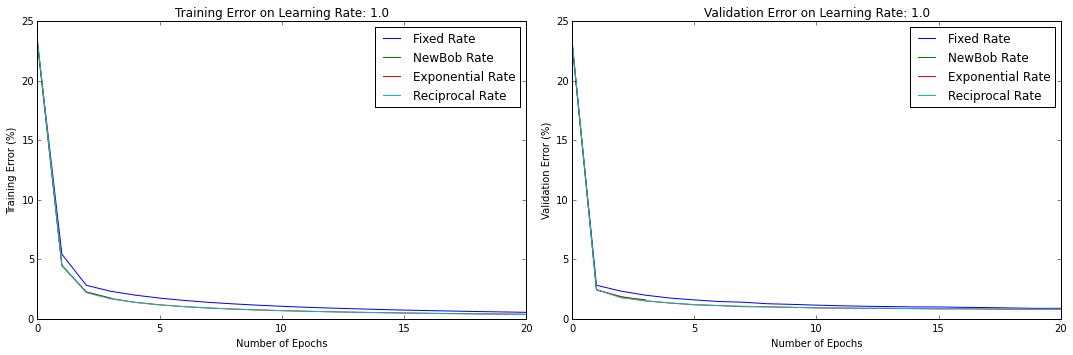

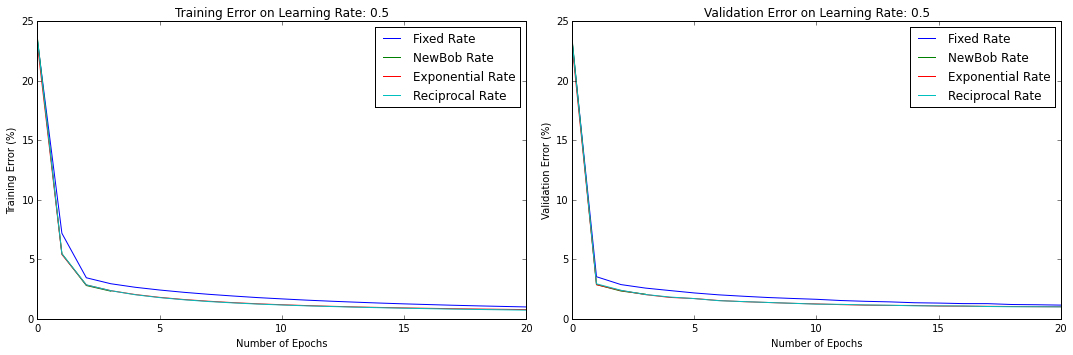

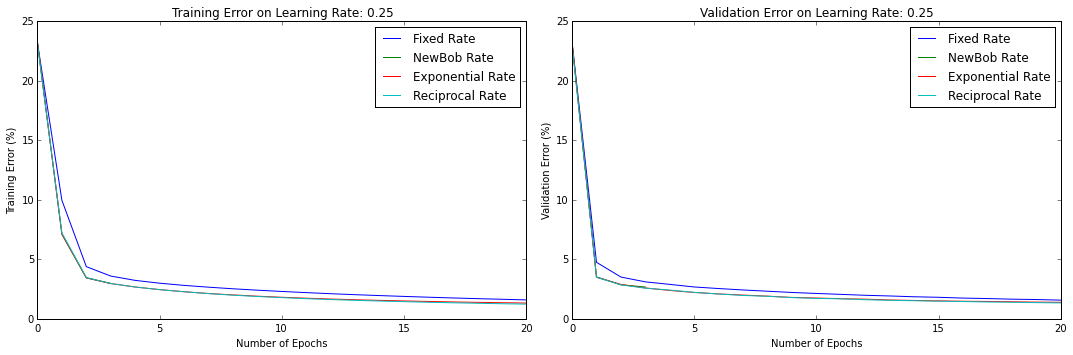

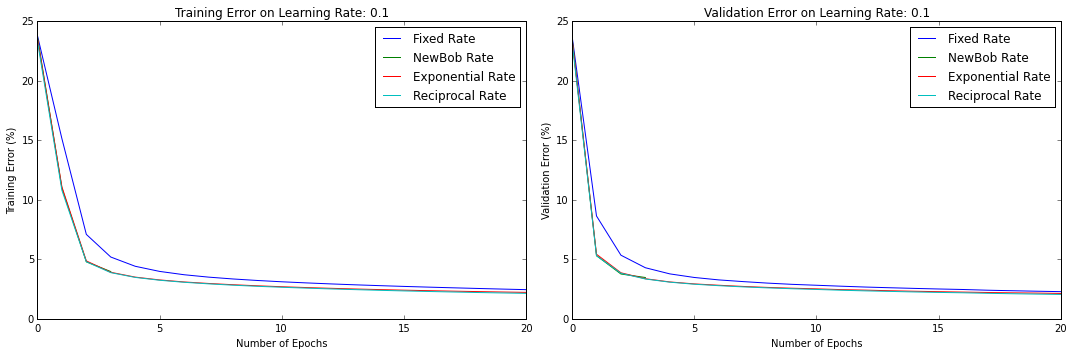

In [8]:
%matplotlib inline

logger.warning("Drawing Graphs...")
counter_learning_rate = 0
for learning_rate_results in stats:
    plt.figure(figsize=(15, 5))
    logger.warning("Learning Rate {0}".format(learning_rates[counter_learning_rate]))

    counter_label = 0
    for result in learning_rate_results:
        (tr_stats, valid_stats, (tst_cost, tst_accuracy)) = result 
        train_accuracies = []
        for stat in tr_stats:
            train_accuracies.append(stat[0]*10)

        validation_accuracies = []
        for stat in valid_stats:
            validation_accuracies.append(stat[0]*10)
        
        plt.subplot(1,2,1)
        plt.plot(train_accuracies, label=labels[counter_label])
        plt.title("Training Error on Learning Rate: {0}".format(learning_rates[counter_learning_rate]))
        plt.xlabel("Number of Epochs")
        plt.ylabel("Training Error (%)")
        plt.legend()
        plt.grid()
        plt.tight_layout()

        plt.subplot(1,2,2)
        plt.plot(validation_accuracies, label=labels[counter_label])
        plt.title("Validation Error on Learning Rate: {0}".format(learning_rates[counter_learning_rate]))
        plt.xlabel("Number of Epochs")
        plt.ylabel("Validation Error (%)")
        plt.legend()
        plt.grid()
        plt.tight_layout()
        
        counter_label += 1
        
    counter_learning_rate += 1
        
    plt.show()


In [ ]:
"""
Observations on Graphs:
The fixed rate was halved to demonstrate that the other rates converge quicker due to how they get smaller, giving us
a minimum error quicker in the gradient decent.
We see that the NewBob, Exponential and Reciprocal rate all give us similar results.
"""

### Task 2 - Experiments with regularisers (5 marks)

Investigate the effect of different regularisation approaches (L1, L2, dropout).  Implement the annealing dropout scheduler (mentioned in lecture 5). Do some further investigations and experiments with model structures (and regularisers) of your choice. 

In [ ]:
class DropoutAnnealing(LearningRateList):

    def __init__(self, p_inp_keep, p_hid_keep, decay):
        assert 0 < p_inp_keep <= 1 and 0 < p_hid_keep <= 1, (
            "Dropout 'keep' probabilites are suppose to be in (0, 1] range"
        )
        self.decay = decay
        super(DropoutAnnealing, self).__init__([(p_inp_keep, p_hid_keep)], max_epochs=999)

    def get_rate(self):
        return self.lr_list[0]

    def get_next_rate(self, current_accuracy=None):
        p_inp, p_hid = self.get_rate()
        self.lr_list[0] = (min(1, p_inp + self.decay), min(1, p_hid + self.decay))
        return p_inp, p_hid
    
"""
Line 1 & 2 here are written above the existing line 3 here in optimisers.py 

if self.dp_scheduler is not None: # line 1
                    self.dp_scheduler.get_next_rate() # line 2
 
self.lr_scheduler.get_next_rate(valid_acc) # line 3

"""

In [40]:
"""
Testing Effects of varying L1 regularisation.
Here, I am recording the weights of both the layers, 
a result of implementing the model with the values contained in the 
test_weights array. 
""" 

nhid = 50
test_weights = [0.1, 0.01, 0.001, 0.0001, 0.00001]
max_epochs = 20
l1_weight = 0.0
l2_weight = 0.0
cost = CECost()
l1_stats = []
l1_weights = []    
layer = 1
logger.setLevel(logging.WARNING)

for test_weight in test_weights:
    learning_rate_results = []

    train_dp.reset()
    valid_dp.reset()
    test_dp.reset()

    #define the model
    model = MLP(cost=cost)
    model.add_layer(Sigmoid(idim=784, odim=nhid, irange=0.2, rng=rng))

    for x in xrange(1, layer):
        logger.info("Stacking hidden layer (%s)" % str(x+1))
        model.add_layer(Sigmoid(idim=nhid, odim=nhid, irange=0.2, rng=rng))

    model.add_layer(Softmax(idim=nhid, odim=10, rng=rng))

    # define the optimiser, here stochasitc gradient descent
    # with fixed learning rate and max_epochs

    lr_scheduler = LearningRateFixed(learning_rate=0.5, max_epochs=max_epochs)

    optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, 
                             dp_scheduler=None,
                             l1_weight=test_weight, 
                             l2_weight=l2_weight)

    logger.warning('Training started for L1 at starting rate {0}'.format(test_weight))

    start_time = time.clock()
    tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)    
    end_time = time.clock()
    logger.warning('Time taken to train: {0}'.format(end_time - start_time))

    logger.warning('Testing the model on test set:')
    tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
    logger.warning('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))

    l1_weights.append((model.layers[0].W, model.layers[1].W))
    l1_stats.append((tr_stats, valid_stats, (tst_cost, tst_accuracy)))
    
logger.warning('Model Testing Complete.')

In [41]:
"""
Testing Effects of varying L2 regularisation.
Here, I am recording the weights of both the layers, 
a result of implementing the model with the values contained in the 
test_weights array. 
""" 
nhid = 50
test_weights = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0]
max_epochs = 20
l1_weight = 0.0
l2_weight = 0.0
cost = CECost()
l2_stats = [] 
l2_weights = []    

layer = 1

for test_weight in test_weights:
    learning_rate_results = []

    train_dp.reset()
    valid_dp.reset()
    test_dp.reset()

    #define the model
    model = MLP(cost=cost)
    model.add_layer(Sigmoid(idim=784, odim=nhid, irange=0.2, rng=rng))

    for x in xrange(1, layer):
        logger.info("Stacking hidden layer (%s)" % str(x+1))
        model.add_layer(Sigmoid(idim=nhid, odim=nhid, irange=0.2, rng=rng))

    model.add_layer(Softmax(idim=nhid, odim=10, rng=rng))

    # define the optimiser, here stochasitc gradient descent
    # with fixed learning rate and max_epochs

    lr_scheduler = LearningRateFixed(learning_rate=0.5, max_epochs=max_epochs)

    optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, 
                             dp_scheduler=None,
                             l1_weight=l1_weight, 
                             l2_weight=test_weight)

    logger.warning('Training started for L2 at starting rate {0}'.format(test_weight))

    start_time = time.clock()
    tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)    
    end_time = time.clock()
    logger.warning('Time taken to train: {0}'.format(end_time - start_time))

    logger.warning('Testing the model on test set:')
    tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
    logger.warning('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))

    l2_weights.append((model.layers[0].W, model.layers[1].W))
    l2_stats.append((tr_stats, valid_stats, (tst_cost, tst_accuracy)))
    
logger.warning('Model Testing Complete.')

In [11]:
"""
Testing Effects of varying both L1 and L2 regularisation
Here, I am recording the weights of both the layers, 
a result of implementing the model with the values contained in the 
test_weights array. 
It is a quick way of seeing which ones have the best values for question 1.5.
Values for best testing accuracy: L1 = 0.0001, L2 = 0.0001.
""" 
nhid = 50
test_weights = [0.01, 0.001, 0.0001, 0.00001, 0]
max_epochs = 20
l1_weight = 0.0
l2_weight = 0.0
cost = CECost()
l1_l2_stats = []  
l1_l2_weights = []    

layer = 1

for test_weight_l1 in test_weights:
    for test_weight_l2 in test_weights:
        learning_rate_results = []

        train_dp.reset()
        valid_dp.reset()
        test_dp.reset()

        #define the model
        model = MLP(cost=cost)
        model.add_layer(Sigmoid(idim=784, odim=nhid, irange=0.2, rng=rng))

        for x in xrange(1, layer):
            logger.info("Stacking hidden layer (%s)" % str(x+1))
            model.add_layer(Sigmoid(idim=nhid, odim=nhid, irange=0.2, rng=rng))

        model.add_layer(Softmax(idim=nhid, odim=10, rng=rng))

        # define the optimiser, here stochasitc gradient descent
        # with fixed learning rate and max_epochs

        lr_scheduler = LearningRateFixed(learning_rate=0.5, max_epochs=max_epochs)

        optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, 
                                 dp_scheduler=None,
                                 l1_weight=test_weight_l1, 
                                 l2_weight=test_weight_l2)

        logger.warning('Training started for L1 at {0} and L2 at {1}'.format(test_weight_l1, test_weight_l2))

        start_time = time.clock()
        tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)    
        end_time = time.clock()
#         logger.warning('Time taken to train: {0}'.format(end_time - start_time))
#         logger.warning('Testing the model on test set:')
        tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
        logger.warning('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))

        
        l1_l2_weights.append((model.layers[0].W, model.layers[1].W))
        l1_l2_stats.append((tr_stats, valid_stats, (tst_cost, tst_accuracy)))
    
logger.warning('Model Testing Complete.')

In [12]:
"""
Testing Effects of the dropout scheduler.
Here, I am recording the weights of both the layers, 
a result of implementing the model with the dropout values contained in the 
dropout_tests array. I attempt it first with a fixed value, and preceed to 
test it with an anealing dropout, increasing the scale of decay through each iteration.
This test is to allow me to see the effect of an annealing dropout with altering 
decays compared to a fixed dropout.
""" 

nhid = 50
test_decays = [0.01, 0.02, 0.05, 0.1, 0.2]
max_epochs = 30
l1_weight = 0.0
l2_weight = 0.0
cost = CECost()
dp_stats = []    
layer = 1

dropout_tests = [
    (DropoutFixed(0.5, 0.5), "DropoutFixed"),
    (DropoutAnnealing(0.5, 0.5, 0.01), "DropoutAnnealing with decay 0.01"),
    (DropoutAnnealing(0.5, 0.5, 0.02), "DropoutAnnealing with decay 0.02"),
    (DropoutAnnealing(0.5, 0.5, 0.05), "DropoutAnnealing with decay 0.05"),
    (DropoutAnnealing(0.5, 0.5, 0.1), "DropoutAnnealing with decay 0.1"),
    (DropoutAnnealing(0.5, 0.5, 0.2), "DropoutAnnealing with decay 0.2")
]

for dropout_test in dropout_tests:

    train_dp.reset()
    valid_dp.reset()
    test_dp.reset()

    #define the model
    model = MLP(cost=cost)
    model.add_layer(Sigmoid(idim=784, odim=nhid, irange=0.2, rng=rng))

    for x in xrange(1, layer):
        logger.info("Stacking hidden layer (%s)" % str(x+1))
        model.add_layer(Sigmoid(idim=nhid, odim=nhid, irange=0.2, rng=rng))

    model.add_layer(Softmax(idim=nhid, odim=10, rng=rng))

    # define the optimiser, here stochasitc gradient descent
    # with fixed learning rate and max_epochs

    lr_scheduler = LearningRateFixed(learning_rate=0.5, max_epochs=max_epochs)

    optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, 
                             dp_scheduler=dropout_test[0],
                             l1_weight=l1_weight, 
                             l2_weight=l2_weight)

    logger.warning('Training started for DP Scheduler {0}'.format(dropout_test[1]))

    start_time = time.clock()
    tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)    
    end_time = time.clock()
#     logger.warning('Time taken to train: {0}'.format(end_time - start_time))

#     logger.warning('Testing the model on test set:')
    tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
    logger.warning('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))

    dp_stats.append((tr_stats, valid_stats, (tst_cost, tst_accuracy)))
    
logger.warning('Model Testing Complete.')

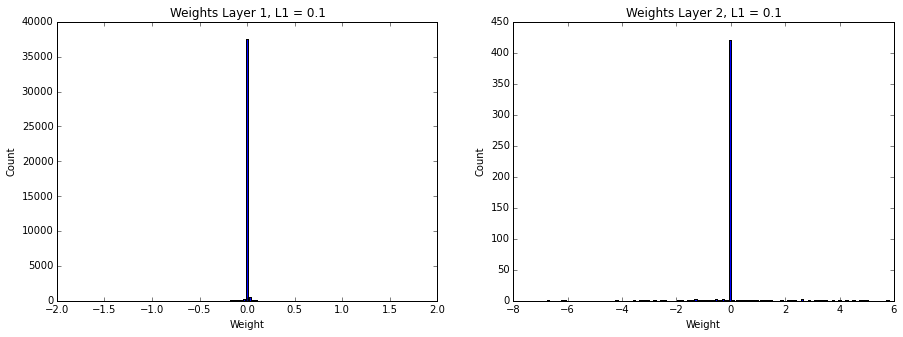

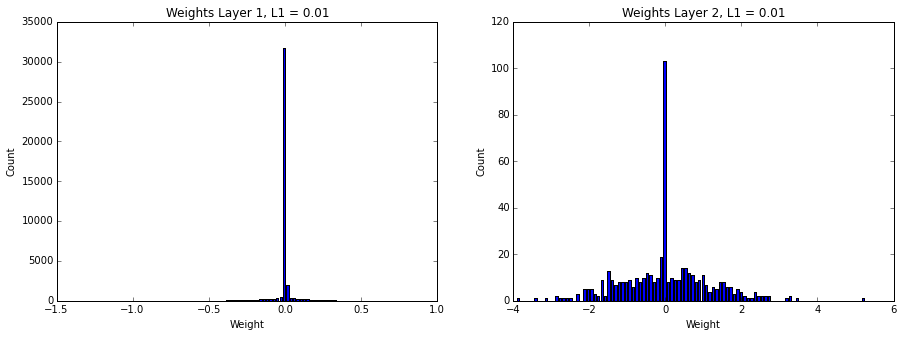

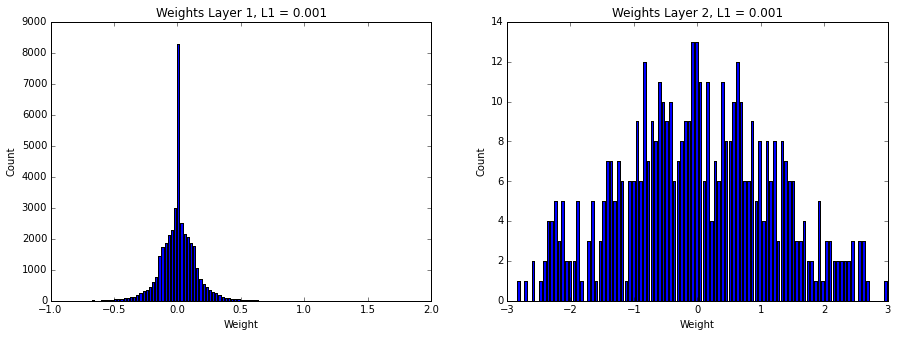

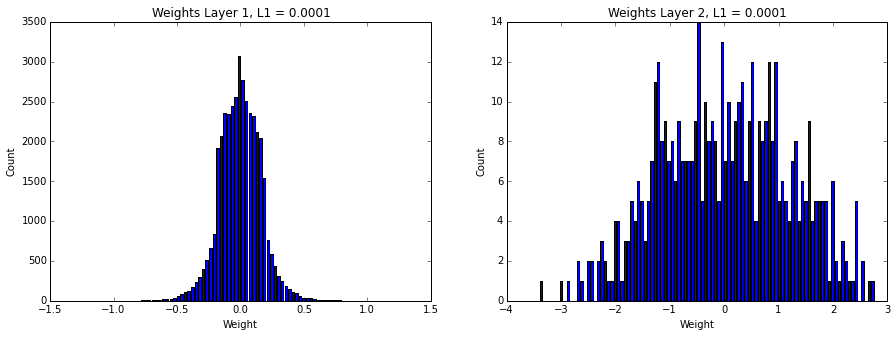

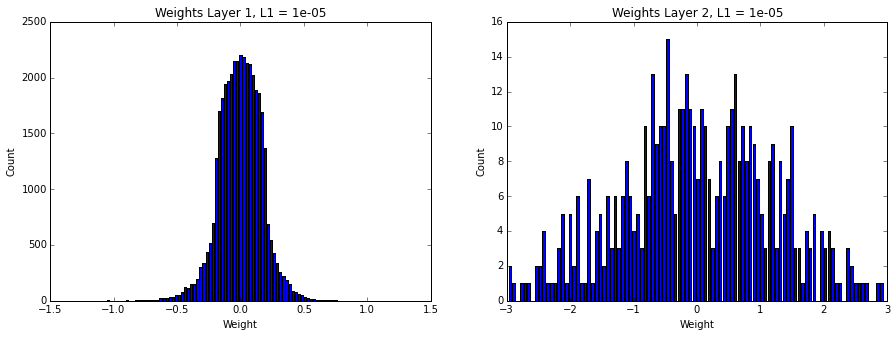

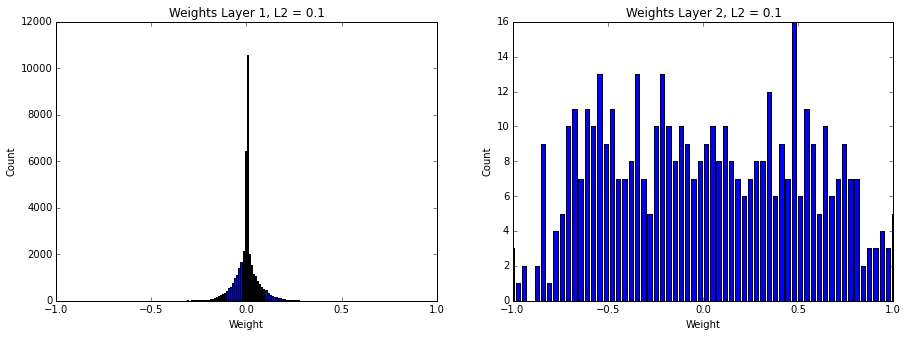

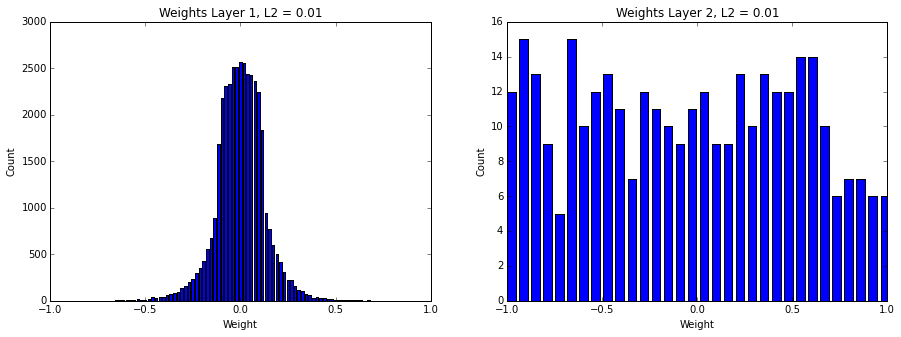

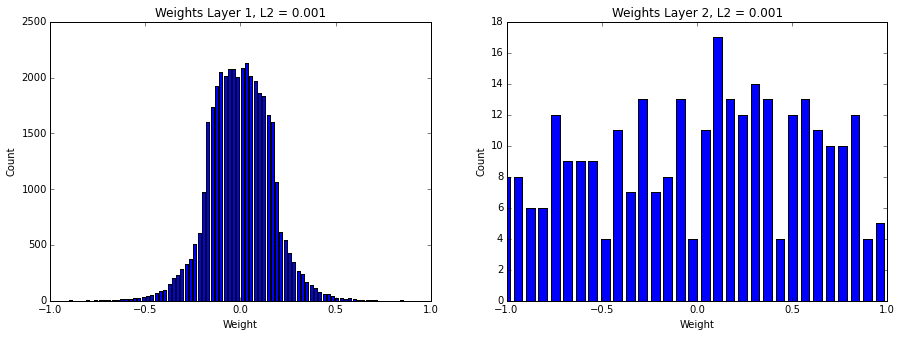

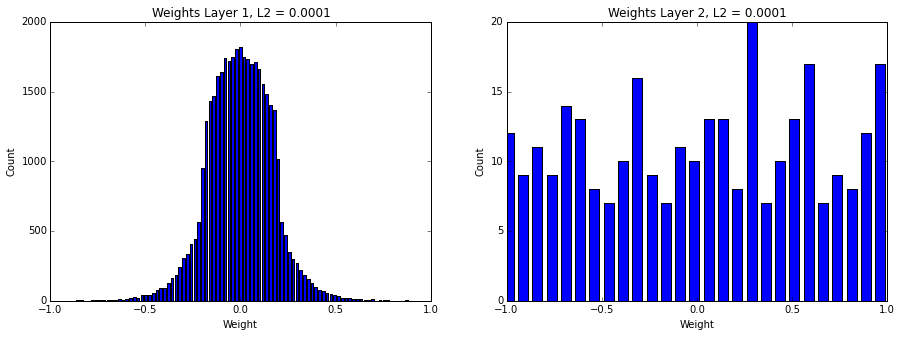

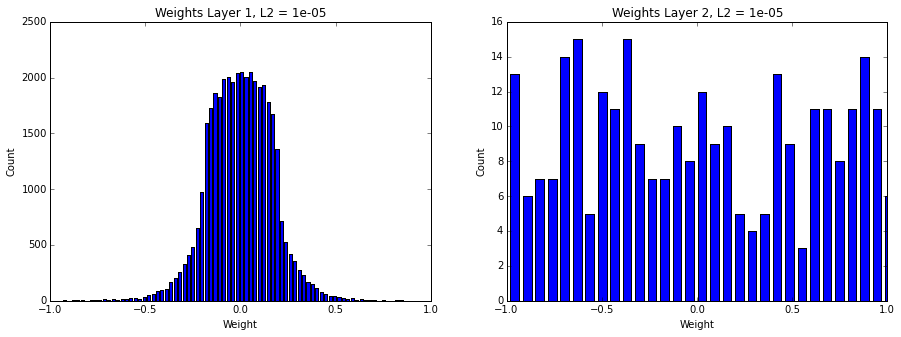

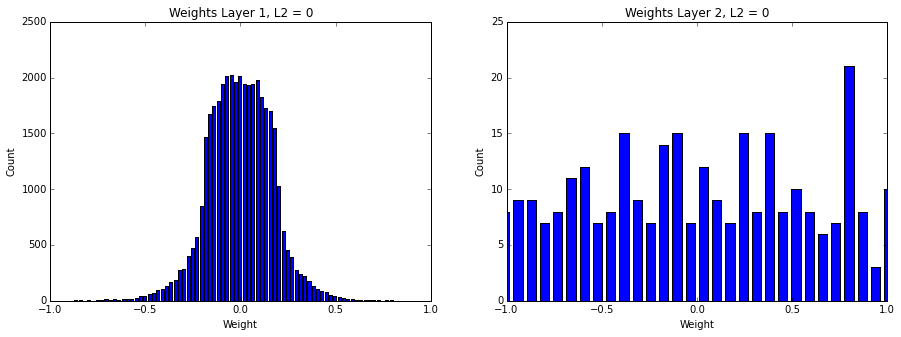

In [44]:
"""
Draw Weights for L1 and L2 Tests. 

I stored the weights of both L1 and L2 in arrays to graph out in this cell.
Here, I am grraphing the weights on a histogram to view their spread based on
L1 and L2 values.
"""
import matplotlib.cm as cm
%matplotlib inline

counter = 0
logger.warning("Drawing L1 Weights...")
for result in l1_weights:
    plt.figure(figsize=(15, 5))
    
    layer0 = result[0]

    plt.subplot(1,2,1)
    plt.title("Weights Layer 1, L1 = {0}".format(test_weights[counter]))
    plt.xlabel("Weight")
    plt.ylabel("Count")
    hist, bins = numpy.histogram(result[0], bins=100)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    
    plt.subplot(1,2,2)
    plt.title("Weights Layer 2, L1 = {0}".format(test_weights[counter]))
    plt.xlabel("Weight")
    plt.ylabel("Count")
    hist, bins = numpy.histogram(result[1], bins=100)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)

    plt.show()

    counter += 1
plt.show()

counter = 0
logger.warning("Drawing L2 Weights...")
for result in l2_weights:
    plt.figure(figsize=(15, 5))
    
    layer0 = result[0]

    plt.subplot(1,2,1)
    plt.title("Weights Layer 1, L2 = {0}".format(test_weights[counter]))
    plt.xlabel("Weight")
    plt.ylabel("Count")
    plt.xlim(-1,1)
    hist, bins = numpy.histogram(result[0], bins=100)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    
    plt.subplot(1,2,2)
    plt.title("Weights Layer 2, L2 = {0}".format(test_weights[counter]))
    plt.xlabel("Weight")
    plt.ylabel("Count")
    plt.xlim(-1,1)
    hist, bins = numpy.histogram(result[1], bins=100)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)

    plt.show()

    counter += 1
    
plt.show()
    


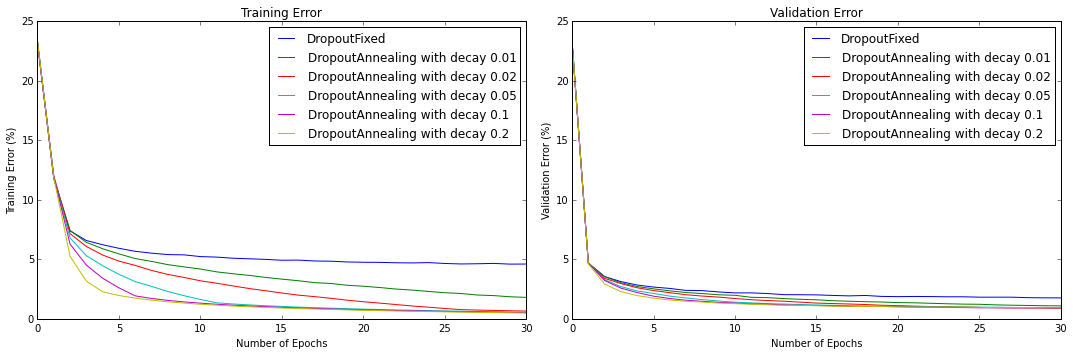

In [14]:
"""
Draw Testing & Validation Errors for Dropout Tests
"""

%matplotlib inline

logger.warning("Drawing Graphs...")
counter = 0
plt.figure(figsize=(15, 5))
for result in dp_stats:

    logger.warning("Drawing Dropout Tests {0}".format(dropout_tests[counter][1]))
    counter_label = 0
    
    (tr_stats, valid_stats, (tst_cost, tst_accuracy)) = result 
    train_accuracies = []
    for stat in tr_stats:
        train_accuracies.append(stat[0]*10)

    validation_accuracies = []
    for stat in valid_stats:
        validation_accuracies.append(stat[0]*10)

    plt.subplot(1,2,1)
    plt.plot(train_accuracies, label=dropout_tests[counter][1])
    plt.title("Training Error")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Training Error (%)")
    plt.legend()
    plt.grid()
    plt.tight_layout()

    plt.subplot(1,2,2)
    plt.plot(validation_accuracies, label=dropout_tests[counter][1])
    plt.title("Validation Error")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Validation Error (%)")
    plt.legend()
    plt.grid()
    plt.tight_layout()

    counter += 1
    
plt.show()


In [ ]:
"""
Observations on L1 and L2 Graphs:
We see that given a larger L1 and L2 value, the weights are concentrated around the middle, 
giving us "dead" nodes, all set to 0. 
While decreasing the value of L1 and L2, this causes the weights to spread 
along the graph, still concentrated in the middle giving us more varied weights.
L1 seems to force all values around 0. 
L2 does the same, but in a more natural curve

Observations on Dropout Graphs:
We see dropout Annealing outperforms dropout fixed. As we iterate through the larger decays, 
it also can be seen that the larger decays not only converge faster but give the best 
accuracy. This can be seen very clearly in the training error, but is also apparent in the
validation error. 
"""

### Task 3 - Experiments with pretraining (15 marks)

Implement pretraining of multi-layer networks with autoencoders, denoising autoencoders, and using  layer-by-layer cross-entropy training.  

Implementation tip: You could add the corresponding methods to `optimiser`, namely, `pretrain()` and `pretrain_epoch()`, for autoencoders. Simiilarly, `pretrain_discriminative()` and `pretrain_epoch_discriminative()` for cross-entropy layer-by-layer pretraining. Of course, you can modify any other necessary pieces, but include all the modified fragments below.

In [ ]:
"""
Note that the Noise class used here is displayed in full on question 4. 
"""

class AutoEncoderOptimiser(Optimiser):
    def __init__(self,
                 learning_rate,
                 max_epochs,
                 dp_scheduler=None,
                 noise=None,
                 l1_weight=0.0,
                 l2_weight=0.0
                ):

        super(AutoEncoderOptimiser, self).__init__()

        self.dp_scheduler = None
        self.noise = noise
        self.l1_weight = l1_weight
        self.l2_weight = l2_weight
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.lr_scheduler = LearningRateFixed(learning_rate=self.learning_rate, max_epochs=self.max_epochs)
        self.cost = MSECost()

    def pre_train(self, model, train_iterator, valid_iterator=None):

        inputs = []

        for x, t in train_iterator:

            inputs.append(x)


        for i in range(0, len(model.layers)-1):
            logger.info('Pre train model i={0}'.format(i))

            self.lr_scheduler = LearningRateFixed(learning_rate=self.learning_rate, max_epochs=self.max_epochs)
            auto_model = MLP(self.cost)

            for j in range(i, i + 1):
                logger.info('Pre train model j={0}'.format(j))
                auto_model.add_layer(model.layers[j])

            auto_model.add_layer(Linear(idim=model.layers[i].odim, odim=model.layers[i].idim))
            self.train(auto_model, inputs)

            temp_model = MLP(self.cost)
            temp_model.add_layer(auto_model.layers[0])

            outputs = []
            for x in inputs:
                outputs.append(temp_model.fprop(x))

            inputs = outputs



    def pre_train_epoch(self, model, train_iterator, learning_rate):
        assert isinstance(model, MLP), (
            "Expected model to be a subclass of 'mlp.layers.MLP'"
            " class but got %s " % type(model)
        )


        acc_list, nll_list = [], []
        for x in train_iterator:

            # get the prediction
            if self.dp_scheduler is not None:
                y = model.fprop_dropout(x, self.dp_scheduler)
            elif self.noise is not None:
                y = model.fprop(self.noise.getAugmentation(x))
            else:
                y = model.fprop(x)

            # compute the cost and grad of the cost w.r.t y
            cost = model.cost.cost(y, x)
            cost_grad = model.cost.grad(y, x)

            # do backward pass through the model
            model.bprop(cost_grad, self.dp_scheduler)

            #update the model, here we iterate over layers
            #and then over each parameter in the layer
            effective_learning_rate = learning_rate / x.shape[0]

            for i in xrange(len(model.layers) - 2, len(model.layers)):
                params = model.layers[i].get_params()
                grads = model.layers[i].pgrads(inputs=model.activations[i],
                                               deltas=model.deltas[i + 1],
                                               l1_weight=self.l1_weight,
                                               l2_weight=self.l2_weight)
                uparams = []
                for param, grad in zip(params, grads):
                    param = param - effective_learning_rate * grad
                    uparams.append(param)
                model.layers[i].set_params(uparams)

            nll_list.append(cost)
            acc_list.append(numpy.mean(self.classification_accuracy(y, x)))

        #compute the prior penalties contribution (parameter dependent only)
        prior_costs = Optimiser.compute_prior_costs(model, self.l1_weight, self.l2_weight)
        training_cost = numpy.mean(nll_list) + sum(prior_costs)

        return training_cost, numpy.mean(acc_list)


    def train(self, model, train_iterator, valid_iterator=None):

        converged = False
        cost_name = model.cost.get_name()
        tr_stats, valid_stats = [], []



        while not converged:

            tstart = time.clock()
            tr_nll, tr_acc = self.pre_train_epoch(model=model,
                                              train_iterator=train_iterator,
                                              learning_rate=self.lr_scheduler.get_rate())
            tr_stats.append((tr_nll, tr_acc))

            logger.info('Epoch %i: Training cost (%s) is %.3f. Accuracy is %.2f%%'
                        % (self.lr_scheduler.epoch + 1, cost_name, tr_nll, tr_acc * 100.))


            self.lr_scheduler.get_next_rate(None)


            #pps = presentations per second
            logger.info("Epoch %i"
                        % (self.lr_scheduler.epoch))

            # we stop training when learning rate, as returned by lr scheduler, is 0
            # this is implementation dependent and depending on lr schedule could happen,
            # for example, when max_epochs has been reached or if the progress between
            # two consecutive epochs is too small, etc.
            converged = (self.lr_scheduler.get_rate() == 0)


class CrossEntropyOptimiser(Optimiser):
    def __init__(self,
                 learning_rate,
                 max_epochs,
                 dp_scheduler=None,
                 l1_weight=0.0,
                 l2_weight=0.0
                ):

        super(CrossEntropyOptimiser, self).__init__()

        self.dp_scheduler = None
        self.l1_weight = l1_weight
        self.l2_weight = l2_weight
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.lr_scheduler = LearningRateFixed(learning_rate=self.learning_rate, max_epochs=self.max_epochs)

    def pre_train(self, model, train_iterator, valid_iterator=None):

        for i in range(0, len(model.layers)-1):
            logger.info('Pre train model i={0}'.format(i))

            self.lr_scheduler = LearningRateFixed(learning_rate=self.learning_rate, max_epochs=self.max_epochs)
            cross_entropy_model = MLP(model.cost)
            for j in range(0, i + 1):
                logger.info('Pre train model j={0}'.format(j))
                cross_entropy_model.add_layer(model.layers[j])
            cross_entropy_model.add_layer(Softmax(idim=model.layers[i].odim, odim=model.layers[-1].odim))
            self.train(cross_entropy_model, train_iterator)


    def pre_train_epoch(self, model, train_iterator, learning_rate):
        assert isinstance(model, MLP), (
            "Expected model to be a subclass of 'mlp.layers.MLP'"
            " class but got %s " % type(model)
        )
        assert isinstance(train_iterator, DataProvider), (
            "Expected iterator to be a subclass of 'mlp.dataset.DataProvider'"
            " class but got %s " % type(train_iterator)
        )

        acc_list, nll_list = [], []
        for x, t in train_iterator:

            # get the prediction
            if self.dp_scheduler is not None:
                y = model.fprop_dropout(x, self.dp_scheduler)
            else:
                y = model.fprop(x)

            # compute the cost and grad of the cost w.r.t y
            cost = model.cost.cost(y, t)
            cost_grad = model.cost.grad(y, t)

            # do backward pass through the model
            model.bprop(cost_grad, self.dp_scheduler)

            #update the model, here we iterate over layers
            #and then over each parameter in the layer
            effective_learning_rate = learning_rate / x.shape[0]

            for i in xrange(len(model.layers) - 2, len(model.layers)):
                params = model.layers[i].get_params()
                grads = model.layers[i].pgrads(inputs=model.activations[i],
                                               deltas=model.deltas[i + 1],
                                               l1_weight=self.l1_weight,
                                               l2_weight=self.l2_weight)
                uparams = []
                for param, grad in zip(params, grads):
                    param = param - effective_learning_rate * grad
                    uparams.append(param)
                model.layers[i].set_params(uparams)

            nll_list.append(cost)
            acc_list.append(numpy.mean(self.classification_accuracy(y, t)))

        #compute the prior penalties contribution (parameter dependent only)
        prior_costs = Optimiser.compute_prior_costs(model, self.l1_weight, self.l2_weight)
        training_cost = numpy.mean(nll_list) + sum(prior_costs)

        return training_cost, numpy.mean(acc_list)


    def train(self, model, train_iterator, valid_iterator=None):

        converged = False
        cost_name = model.cost.get_name()
        tr_stats, valid_stats = [], []

        # do the initial validation
        train_iterator.reset()
        tr_nll, tr_acc = self.validate(model, train_iterator, self.l1_weight, self.l2_weight)
        logger.info('Epoch %i: Training cost (%s) for initial model is %.3f. Accuracy is %.2f%%'
                    % (self.lr_scheduler.epoch, cost_name, tr_nll, tr_acc * 100.))
        tr_stats.append((tr_nll, tr_acc))

        while not converged:
            train_iterator.reset()

            tstart = time.clock()
            tr_nll, tr_acc = self.pre_train_epoch(model=model,
                                              train_iterator=train_iterator,
                                              learning_rate=self.lr_scheduler.get_rate())
            tr_stats.append((tr_nll, tr_acc))

            logger.info('Epoch %i: Training cost (%s) is %.3f. Accuracy is %.2f%%'
                        % (self.lr_scheduler.epoch + 1, cost_name, tr_nll, tr_acc * 100.))

            if valid_iterator is not None:
                valid_iterator.reset()
                valid_nll, valid_acc = self.validate(model, valid_iterator,
                                                     self.l1_weight, self.l2_weight)
                logger.info('Epoch %i: Validation cost (%s) is %.3f. Accuracy is %.2f%%'
                            % (self.lr_scheduler.epoch + 1, cost_name, valid_nll, valid_acc * 100.))

                if self.dp_scheduler is not None:
                    self.dp_scheduler.get_next_rate()


                self.lr_scheduler.get_next_rate(valid_acc)
                valid_stats.append((valid_nll, valid_acc))
            else:
                self.lr_scheduler.get_next_rate(None)


            #pps = presentations per second
            logger.info("Epoch %i"
                        % (self.lr_scheduler.epoch))

            # we stop training when learning rate, as returned by lr scheduler, is 0
            # this is implementation dependent and depending on lr schedule could happen,
            # for example, when max_epochs has been reached or if the progress between
            # two consecutive epochs is too small, etc.
            converged = (self.lr_scheduler.get_rate() == 0)



In [30]:
"""
Testing Effects of my Cross entropy optimiser with respect to the amount of epochs in the optimiser.

""" 
logger.setLevel(logging.WARNING)
nhid = 73
optimiser_epochs = [1, 3, 5, 10, 20]
max_epochs = 10
l1_weight = 0.0
l2_weight = 0.0
cost = CECost()
dp_stats = []    
layer = 5
cross_entropy_stats = []


for optimiser_epoch in optimiser_epochs:
    
    train_dp.reset()
    valid_dp.reset()
    test_dp.reset()

    #define the model
    model = MLP(cost=cost)
    model.add_layer(Sigmoid(idim=784, odim=nhid, irange=0.2, rng=rng))

    for x in xrange(1, layer):
        logger.info("Stacking hidden layer (%s)" % str(x+1))
        model.add_layer(Sigmoid(idim=nhid, odim=nhid, irange=0.2, rng=rng))

    model.add_layer(Softmax(idim=nhid, odim=10, rng=rng))

    # define the optimiser, here stochasitc gradient descent
    # with fixed learning rate and max_epochs

    logger.warning('Cross Entropy Training started for {0} epochs...'.format(optimiser_epoch))

    optimiser = CrossEntropyOptimiser(learning_rate=0.5, 
                                      max_epochs=optimiser_epoch,
                                     dp_scheduler=None,
                                     l1_weight=l1_weight, 
                                     l2_weight=l2_weight)

    optimiser.pre_train(model, train_dp, valid_dp)

    lr_scheduler = LearningRateFixed(learning_rate=0.5, max_epochs=max_epochs)

    optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, 
                             dp_scheduler=None,
                             l1_weight=l1_weight, 
                             l2_weight=l2_weight)

    logger.warning('Training started...'.format())

    start_time = time.clock()
    tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)    
    end_time = time.clock()

    logger.warning('Time taken to train: {0}'.format(end_time - start_time))
    tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
    logger.warning('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))

    cross_entropy_stats.append((tr_stats, valid_stats, (tst_cost, tst_accuracy)))

logger.warning('Model Testing Complete.')

In [14]:
"""
Testing Effects of my Auto Encoder optimiser with respect to the number of epochs in the optimiser.

""" 
logger.setLevel(logging.WARNING)
nhid = 73
optimiser_epochs = [1, 3, 5, 10, 20]
max_epochs = 20
l1_weight = 0.0
l2_weight = 0.0
cost = CECost()
dp_stats = []    
layer = 5
auto_encoder_epoch_stats = []

for optimiser_epoch in optimiser_epochs:
    
    train_dp.reset()
    valid_dp.reset()
    test_dp.reset()

    #define the model
    model = MLP(cost=cost)
    model.add_layer(Sigmoid(idim=784, odim=nhid, irange=0.2, rng=rng))

    for x in xrange(1, layer):
        logger.info("Stacking hidden layer (%s)" % str(x+1))
        model.add_layer(Sigmoid(idim=nhid, odim=nhid, irange=0.2, rng=rng))

    model.add_layer(Softmax(idim=nhid, odim=10, rng=rng))

    # define the optimiser, here stochasitc gradient descent
    # with fixed learning rate and max_epochs

    logger.warning('Auto Encoder Training started for {0} Optimiser Epochs...'.format(optimiser_epoch))

    auto_noise = DropOutNoise(0.7, rng)
        
    optimiser = AutoEncoderOptimiser(learning_rate=0.1, 
                                     max_epochs=optimiser_epoch,
                                     noise=auto_noise,
                                     dp_scheduler=None,
                                     l1_weight=l1_weight, 
                                     l2_weight=l2_weight)

    optimiser.pre_train(model, train_dp, valid_dp)

    lr_scheduler = LearningRateFixed(learning_rate=0.5, max_epochs=max_epochs)

    optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, 
                             dp_scheduler=None,
                             l1_weight=l1_weight, 
                             l2_weight=l2_weight)

    logger.warning('Training started...'.format())

    start_time = time.clock()
    tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)    
    end_time = time.clock()

    logger.warning('Time taken to train: {0}'.format(end_time - start_time))
    tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
    logger.warning('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))

    auto_encoder_epoch_stats.append((tr_stats, valid_stats, (tst_cost, tst_accuracy)))

logger.warning('Model Testing Complete.')

In [13]:
"""
Testing Effects of my Noisy Auto Encoder optimiser with respect to the value of noise given.

""" 
logger.setLevel(logging.WARNING)
nhid = 73
test_noises = [1, 0.9, 0.7, 0.5, 0.3]
max_epochs = 20
l1_weight = 0.0
l2_weight = 0.0
cost = CECost()
dp_stats = []    
layer = 5
auto_encoder_noise_stats = []

for test_noise in test_noises:
    
    train_dp.reset()
    valid_dp.reset()
    test_dp.reset()

    #define the model
    model = MLP(cost=cost)
    model.add_layer(Sigmoid(idim=784, odim=nhid, irange=0.2, rng=rng))

    for x in xrange(1, layer):
        logger.info("Stacking hidden layer (%s)" % str(x+1))
        model.add_layer(Sigmoid(idim=nhid, odim=nhid, irange=0.2, rng=rng))

    model.add_layer(Softmax(idim=nhid, odim=10, rng=rng))

    # define the optimiser, here stochasitc gradient descent
    # with fixed learning rate and max_epochs

    logger.warning('Auto Encoder Training started for {0} Noise...'.format(test_noise))

    noise_percent = 0.7
    
    if auto_noise is not 1:
        auto_noise = DropOutNoise(test_noise, rng)
    else:
        auto_noise = None
        
    optimiser = AutoEncoderOptimiser(learning_rate=0.1, 
                                     max_epochs=5,
                                     noise=auto_noise,
                                     dp_scheduler=None,
                                     l1_weight=l1_weight, 
                                     l2_weight=l2_weight)

    optimiser.pre_train(model, train_dp, valid_dp)

    lr_scheduler = LearningRateFixed(learning_rate=0.5, max_epochs=max_epochs)

    optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, 
                             dp_scheduler=None,
                             l1_weight=l1_weight, 
                             l2_weight=l2_weight)

    logger.warning('Training started...'.format())

    start_time = time.clock()
    tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)    
    end_time = time.clock()

    logger.warning('Time taken to train: {0}'.format(end_time - start_time))
    tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
    logger.warning('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))

    auto_encoder_noise_stats.append((tr_stats, valid_stats, (tst_cost, tst_accuracy)))

logger.warning('Model Testing Complete.')

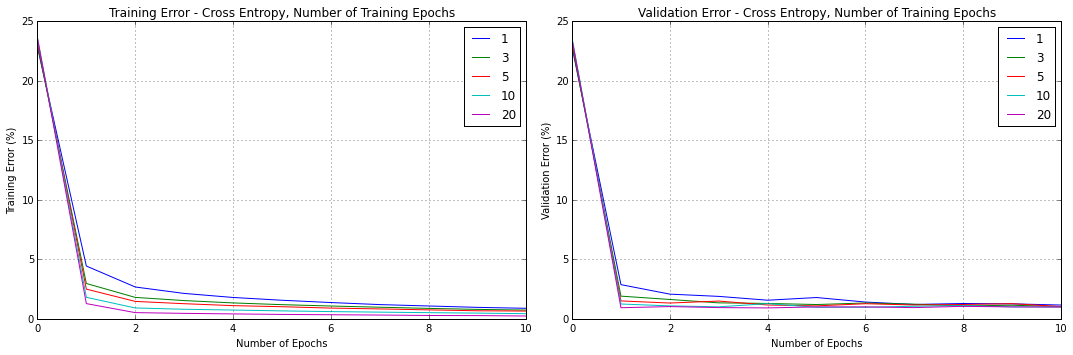

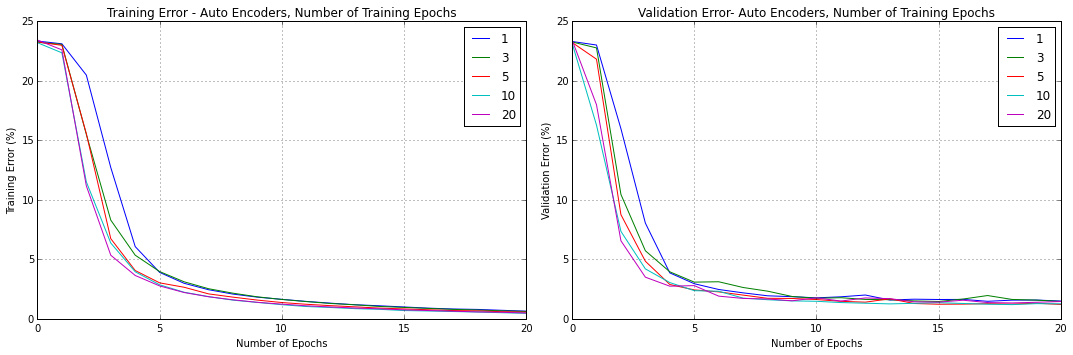

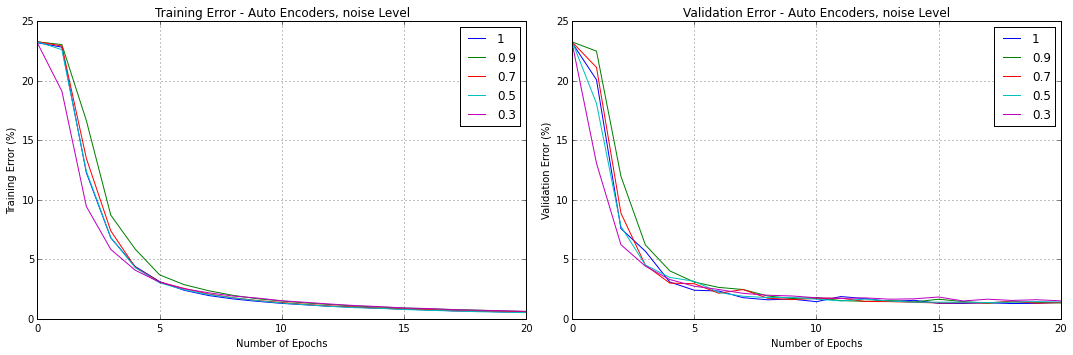

In [31]:
"""
Draw Testing & Validation Errors for Q3 Tests
"""

%matplotlib inline

logger.warning("Drawing Graphs...")
counter = 0
plt.figure(figsize=(15, 5))
for result in cross_entropy_stats:

    logger.warning("Drawing Cross Entropy Tests {0}".format(optimiser_epochs[counter]))
    counter_label = 0
    
    (tr_stats, valid_stats, (tst_cost, tst_accuracy)) = result 
    train_accuracies = []
    for stat in tr_stats:
        train_accuracies.append(stat[0]*10)

    validation_accuracies = []
    for stat in valid_stats:
        validation_accuracies.append(stat[0]*10)

    plt.subplot(1,2,1)
    plt.plot(train_accuracies, label=optimiser_epochs[counter])
    plt.title("Training Error - Cross Entropy, Number of Training Epochs")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Training Error (%)")
    plt.legend()
    plt.grid()
    plt.tight_layout()

    plt.subplot(1,2,2)
    plt.plot(validation_accuracies, label=optimiser_epochs[counter])
    plt.title("Validation Error - Cross Entropy, Number of Training Epochs")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Validation Error (%)")
    plt.legend()
    plt.grid()
    plt.tight_layout()

    counter += 1
    
plt.show()

counter = 0
plt.figure(figsize=(15, 5))
for result in auto_encoder_epoch_stats:

    logger.warning("Drawing Auto Encoder Epoch Tests {0}".format(optimiser_epochs[counter]))
    counter_label = 0
    
    (tr_stats, valid_stats, (tst_cost, tst_accuracy)) = result 
    train_accuracies = []
    for stat in tr_stats:
        train_accuracies.append(stat[0]*10)

    validation_accuracies = []
    for stat in valid_stats:
        validation_accuracies.append(stat[0]*10)

    plt.subplot(1,2,1)
    plt.plot(train_accuracies, label=optimiser_epochs[counter])
    plt.title("Training Error - Auto Encoders, Number of Training Epochs")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Training Error (%)")
    plt.legend()
    plt.grid()
    plt.tight_layout()

    plt.subplot(1,2,2)
    plt.plot(validation_accuracies, label=optimiser_epochs[counter])
    plt.title("Validation Error- Auto Encoders, Number of Training Epochs")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Validation Error (%)")
    plt.legend()
    plt.grid()
    plt.tight_layout()

    counter += 1
    
plt.show()

counter = 0
plt.figure(figsize=(15, 5))
for result in auto_encoder_noise_stats:

    logger.warning("Drawing Auto Encoder Noise Stats {0}".format(test_noises[counter]))
    counter_label = 0
    
    (tr_stats, valid_stats, (tst_cost, tst_accuracy)) = result 
    train_accuracies = []
    for stat in tr_stats:
        train_accuracies.append(stat[0]*10)

    validation_accuracies = []
    for stat in valid_stats:
        validation_accuracies.append(stat[0]*10)

    plt.subplot(1,2,1)
    plt.plot(train_accuracies, label=test_noises[counter])
    plt.title("Training Error - Auto Encoders, noise Level")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Training Error (%)")
    plt.legend()
    plt.grid()
    plt.tight_layout()

    plt.subplot(1,2,2)
    plt.plot(validation_accuracies, label=test_noises[counter])
    plt.title("Validation Error - Auto Encoders, noise Level")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Validation Error (%)")
    plt.legend()
    plt.grid()
    plt.tight_layout()

    counter += 1
    
plt.show()



In [ ]:
"""
Comments on Graphs

Cross Entropy Number of Optimiser Epochs
We see that increasing the number of Epochs on the Cross Entropy Optimiser not only increases
the overall accuracy, but also enables it to converge faster.

Auto Encoder - Number of Optimiser Epochs
We see that increasing the number of Epochs on the Auto Encoder Optimiser not only increases
the overall accuracy, but also enables it to converge faster.

Auto Encoder - Noise Level
Decreasing Noise to a lower level allows it to converge faster, but generally has a minimal effect on the 
overall accuraccy after it converges. 

"""

In [14]:
"""
Running all three experiments (Cross Entropy, Auto Encoder, Noisy Auto Encoder) in an effort to see the impact of 
different layers. 
"""

logger.setLevel(logging.WARNING)
nhid = 73
optimiser_types = [1,2,3]
optimiser_type = 1
model_layers = [1,3,5,7]
max_epochs = 20
l1_weight = 0.0
l2_weight = 0.0
cost = CECost()
dp_stats = []    
layer = 5
cross_entropy_layer_stats = []
autoencoder_layer_stats = []
noisy_autoencoder_layer_stats = []

for optimiser_type in optimiser_types:
    for model_layer in model_layers:

        train_dp.reset()
        valid_dp.reset()
        test_dp.reset()

        #define the model
        model = MLP(cost=cost)
        model.add_layer(Sigmoid(idim=784, odim=nhid, irange=0.2, rng=rng))

        for x in xrange(1, model_layer):
            logger.info("Stacking hidden layer (%s)" % str(x+1))
            model.add_layer(Sigmoid(idim=nhid, odim=nhid, irange=0.2, rng=rng))

        model.add_layer(Softmax(idim=nhid, odim=10, rng=rng))

        # define the optimiser, here stochasitc gradient descent
        # with fixed learning rate and max_epochs

        if optimiser_type == 1:
            optimiser = CrossEntropyOptimiser(learning_rate=0.5, 
                                          max_epochs=5,
                                         dp_scheduler=None,
                                         l1_weight=l1_weight, 
                                         l2_weight=l2_weight)
            logger.warning('Cross Entropy Training started for {0} layers...'.format(model_layer))

        elif optimiser_type == 2:
            optimiser = AutoEncoderOptimiser(learning_rate=0.1, 
                                         max_epochs=5,
                                         noise=None,
                                         dp_scheduler=None,
                                         l1_weight=l1_weight, 
                                         l2_weight=l2_weight)
            logger.warning('Auto Encoder Training started for {0} layers...'.format(model_layer))

        elif optimiser_type == 3:
            auto_noise = DropOutNoise(0.3, rng)
            optimiser = AutoEncoderOptimiser(learning_rate=0.1, 
                                         max_epochs=5,
                                         noise=auto_noise,
                                         dp_scheduler=None,
                                         l1_weight=l1_weight, 
                                         l2_weight=l2_weight)
            logger.warning('Noisy Auto Encoder Training started for {0} layers...'.format(model_layer))



        optimiser.pre_train(model, train_dp, valid_dp)

        lr_scheduler = LearningRateFixed(learning_rate=0.5, max_epochs=max_epochs)

        optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, 
                                 dp_scheduler=None,
                                 l1_weight=l1_weight, 
                                 l2_weight=l2_weight)

        logger.warning('Training started...'.format())

        start_time = time.clock()
        tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)    
        end_time = time.clock()

    #     logger.warning('Time taken to train: {0}'.format(end_time - start_time))
        tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
        logger.warning('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))

        if optimiser_type == 1:
            cross_entropy_layer_stats.append((tr_stats, valid_stats, (tst_cost, tst_accuracy)))
        elif optimiser_type == 2:
            autoencoder_layer_stats.append((tr_stats, valid_stats, (tst_cost, tst_accuracy)))
        elif optimiser_type == 3:
            noisy_autoencoder_layer_stats.append((tr_stats, valid_stats, (tst_cost, tst_accuracy)))


logger.warning('Model Testing Complete.')

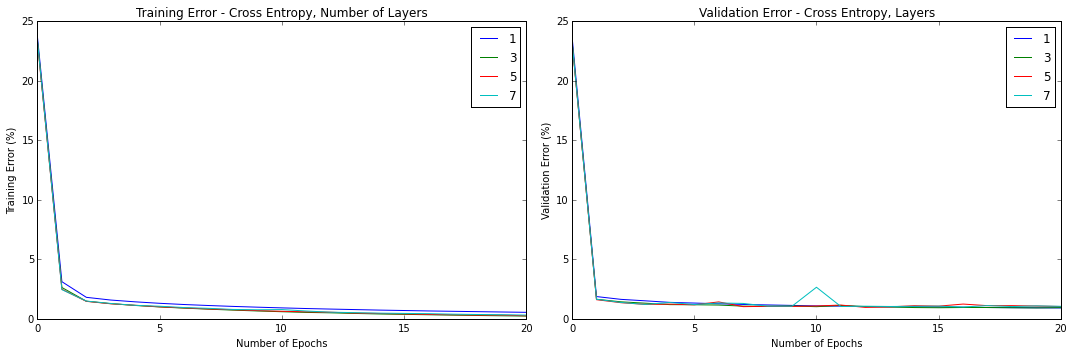

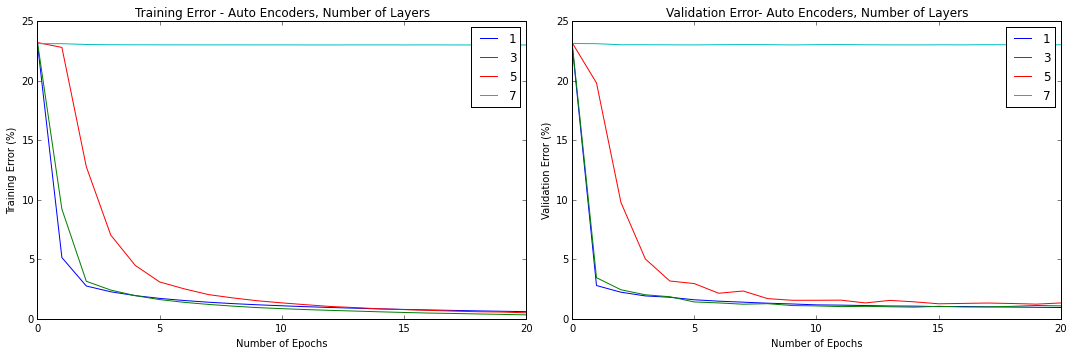

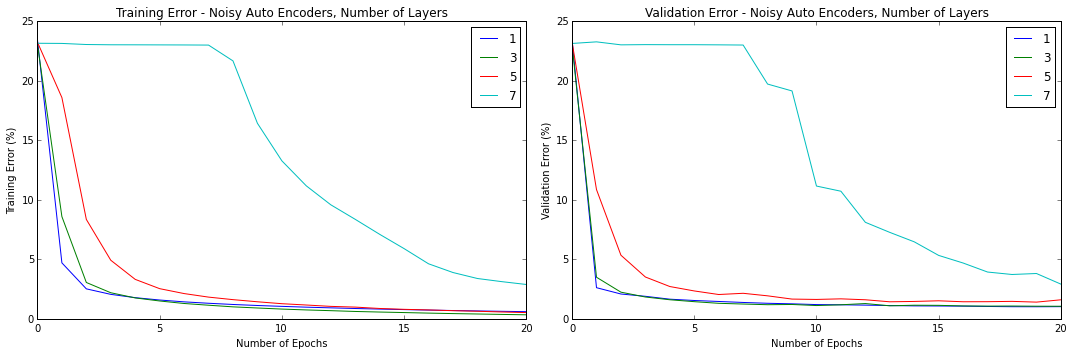

In [17]:
"""
Drawing different graphs for each type of optimiser's result from the above experiment.
"""

%matplotlib inline

logger.warning("Drawing Graphs...")
counter = 0
plt.figure(figsize=(15, 5))
for result in cross_entropy_layer_stats:

    logger.warning("Drawing Cross Entropy Tests with number of layers {0}".format(model_layers[counter]))
    counter_label = 0
    
    (tr_stats, valid_stats, (tst_cost, tst_accuracy)) = result 
    train_accuracies = []
    for stat in tr_stats:
        train_accuracies.append(stat[0]*10)

    validation_accuracies = []
    for stat in valid_stats:
        validation_accuracies.append(stat[0]*10)

    plt.subplot(1,2,1)
    plt.plot(train_accuracies, label=model_layers[counter])
    plt.title("Training Error - Cross Entropy, Number of Layers")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Training Error (%)")
    plt.legend()
    plt.grid()
    plt.tight_layout()

    plt.subplot(1,2,2)
    plt.plot(validation_accuracies, label=model_layers[counter])
    plt.title("Validation Error - Cross Entropy, Layers")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Validation Error (%)")
    plt.legend()
    plt.grid()
    plt.tight_layout()

    counter += 1
    
plt.show()

counter = 0
plt.figure(figsize=(15, 5))
for result in autoencoder_layer_stats:

    logger.warning("Drawing Auto Encoder with Number of Layers {0}".format(model_layers[counter]))
    counter_label = 0
    
    (tr_stats, valid_stats, (tst_cost, tst_accuracy)) = result 
    train_accuracies = []
    for stat in tr_stats:
        train_accuracies.append(stat[0]*10)

    validation_accuracies = []
    for stat in valid_stats:
        validation_accuracies.append(stat[0]*10)

    plt.subplot(1,2,1)
    plt.plot(train_accuracies, label=model_layers[counter])
    plt.title("Training Error - Auto Encoders, Number of Layers")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Training Error (%)")
    plt.legend()
    plt.grid()
    plt.tight_layout()

    plt.subplot(1,2,2)
    plt.plot(validation_accuracies, label=model_layers[counter])
    plt.title("Validation Error- Auto Encoders, Number of Layers")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Validation Error (%)")
    plt.legend()
    plt.grid()
    plt.tight_layout()

    counter += 1
    
plt.show()

counter = 0
plt.figure(figsize=(15, 5))
for result in noisy_autoencoder_layer_stats:

    logger.warning("Drawing Auto Encoder Noise with Number of Layers {0}".format(model_layers[counter]))
    counter_label = 0
    
    (tr_stats, valid_stats, (tst_cost, tst_accuracy)) = result 
    train_accuracies = []
    for stat in tr_stats:
        train_accuracies.append(stat[0]*10)

    validation_accuracies = []
    for stat in valid_stats:
        validation_accuracies.append(stat[0]*10)

    plt.subplot(1,2,1)
    plt.plot(train_accuracies, label=model_layers[counter])
    plt.title("Training Error - Noisy Auto Encoders, Number of Layers")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Training Error (%)")
    plt.legend()
    plt.grid()
    plt.tight_layout()

    plt.subplot(1,2,2)
    plt.plot(validation_accuracies, label=model_layers[counter])
    plt.title("Validation Error - Noisy Auto Encoders, Number of Layers")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Validation Error (%)")
    plt.legend()
    plt.grid()
    plt.tight_layout()

    counter += 1
    
plt.show()



In [ ]:
"""
With my cross entropy graphs, we see that models with >1 layer perform slightly better than a model with 1 layer.
Increasing the layer depth doesn't seem to have much of an effect other than a bizzare spike on 7 layers.

With my Auto Encoder, we see that the lower the number of layers, the better the accuracy. My 7 layer model doesn't
even converge within the 20 epochs.

With my noisy auto encoder, we see a pretty similar result to the one above with the exception of the 7 layer network 
converges within the 20 epochs. 

Cross Entropy here seemed to me to be the best one for MNIST. 

It should also be noted that nhid was set to 73, optimised for 5 layers. This shouldn't have much of an effect,
but if I had had more time, I would've calculated unique values for nhid on each respective layer. 
"""

### Task 4 - Experiments with data augmentation (5 marks)

Using the standard MNIST training data, generate some augmented training examples (for example, using noise or rotation). Perform experiments on using this expanded training data.

In [ ]:
"""
These are my classes that augment and add training examples to the dataset.
"""

import numpy

class Augmenter(object):

    def __init__(self, dataset, number_of_batches, augmentation):
        self.dataset = dataset
        self.number_of_batches = number_of_batches
        self.augmentation = augmentation
        self.batch_size = self.dataset.batch_size

    def get_new_batch(self):

        augmented_data = []
        augmented_labels = []

        for i in range(0, self.number_of_batches * self.batch_size):
            img = self.dataset.x[i]
            label = self.dataset.t[i]
            image = self.augmentation.getAugmentation(img)

            augmented_data.append(image)
            augmented_labels.append(label)

        self.dataset.t = numpy.concatenate((self.dataset.t, augmented_labels), axis=0)
        self.dataset.x = numpy.concatenate((self.dataset.x, augmented_data), axis=0)


class AbstractAugmentation(object):

    def getAugmentation(self, img):
        return img


class DropOutNoise(AbstractAugmentation):

    def __init__(self, percent, rng):
        self.percent = percent
        self.rng = rng

    def getAugmentation(self, img):

        d = self.rng.binomial(1, self.percent, img.shape)

        return d * img

class DropOutRotation(AbstractAugmentation):

    def getAugmentation(self, img):
        img = img.reshape(28, 28)
        return numpy.rot90(img).reshape(784)

In [5]:
"""
Testing Effects of varying the DropOutNoise percentage on the augmented_dp.
""" 

%pylab
%matplotlib inline
from mlp.noise import DropOutNoise, Augmenter

nhid = 50
augmented_percentages = [0.99, 0.9, 0.8, 0.7, 0.5, 0.2]
max_epochs = 20
l1_weight = 0.0
l2_weight = 0.0
cost = CECost()   
layer = 1
noise_stats = []    


for augmented_percentage in augmented_percentages:

    logger.warning("Setting up Augmented_dp for {0}% DropOutNoise".format(augmented_percentage))
    augmented_dp = MNISTDataProvider(dset='train', batch_size=100, max_num_batches=-10, randomize=True)
    augmentation = DropOutNoise(augmented_percentage,rng)
    Augmenter(dataset=augmented_dp, number_of_batches=200, augmentation=augmentation).get_new_batch()
    
    train_dp.reset()
    valid_dp.reset()
    test_dp.reset()

    #define the model
    model = MLP(cost=cost)
    model.add_layer(Sigmoid(idim=784, odim=nhid, irange=0.2, rng=rng))

    for x in xrange(1, layer):
        logger.info("Stacking hidden layer (%s)" % str(x+1))
        model.add_layer(Sigmoid(idim=nhid, odim=nhid, irange=0.2, rng=rng))

    model.add_layer(Softmax(idim=nhid, odim=10, rng=rng))

    lr_scheduler = LearningRateFixed(learning_rate=0.5, max_epochs=max_epochs)

    optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, 
                             dp_scheduler=None,
                             l1_weight=l1_weight, 
                             l2_weight=l2_weight)

    logger.warning('Training started for noise at {0}%'.format(augmented_percentage))

    start_time = time.clock()
    tr_stats, valid_stats = optimiser.train(model, augmented_dp, valid_dp)    
    end_time = time.clock()
    logger.warning('Time taken to train: {0}'.format(end_time - start_time))

    logger.warning('Testing the model on test set:')
    tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
    logger.warning('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))
    noise_stats.append((tr_stats, valid_stats, (tst_cost, tst_accuracy)))
    
logger.warning('Model Testing Complete.')



Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [4]:
"""
Testing Effects of varying the increased batch size on the augmented_dp.
""" 

%pylab
%matplotlib inline
from mlp.noise import DropOutNoise, Augmenter

nhid = 50
augmented_percentage = 0.8
augmented_number_of_batches = [1, 100, 200, 500]
max_epochs = 20
l1_weight = 0.0
l2_weight = 0.0
cost = CECost()   
layer = 1
batch_stats = []    


for augmented_number_of_batche in augmented_number_of_batches:

    logger.warning("Setting up Augmented_dp for batch size {0}".format(augmented_number_of_batche))
    augmented_dp = MNISTDataProvider(dset='train', batch_size=100, max_num_batches=-10, randomize=True)
    augmentation = DropOutNoise(augmented_percentage,rng)
    Augmenter(dataset=augmented_dp, number_of_batches=100, augmentation=augmentation).get_new_batch()
    
    train_dp.reset()
    valid_dp.reset()
    test_dp.reset()

    #define the model
    model = MLP(cost=cost)
    model.add_layer(Sigmoid(idim=784, odim=nhid, irange=0.2, rng=rng))

    for x in xrange(1, layer):
        logger.info("Stacking hidden layer (%s)" % str(x+1))
        model.add_layer(Sigmoid(idim=nhid, odim=nhid, irange=0.2, rng=rng))

    model.add_layer(Softmax(idim=nhid, odim=10, rng=rng))

    lr_scheduler = LearningRateFixed(learning_rate=0.5, max_epochs=max_epochs)

    optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, 
                             dp_scheduler=None,
                             l1_weight=l1_weight, 
                             l2_weight=l2_weight)

    logger.warning('Training started for number of Batches: {0} '.format(augmented_number_of_batche))

    start_time = time.clock()
    tr_stats, valid_stats = optimiser.train(model, augmented_dp, valid_dp)    
    end_time = time.clock()
    logger.warning('Time taken to train: {0}'.format(end_time - start_time))

    logger.warning('Testing the model on test set:')
    tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
    logger.warning('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))
    batch_stats.append((tr_stats, valid_stats, (tst_cost, tst_accuracy)))
    
logger.warning('Model Testing Complete.')



Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [3]:
"""
Testing Effects of varying the batch size on rotation elements in the augmented_dp.
""" 

%pylab
%matplotlib inline
from mlp.noise import DropOutNoise, Augmenter

nhid = 50
augmented_percentage = 0.8
rotation_augmented_number_of_batches = [1, 100, 200, 500]
max_epochs = 20
l1_weight = 0.0
l2_weight = 0.0
cost = CECost()   
layer = 1
rotation_batch_stats = []    


for rotation_augmented_number_of_batche in rotation_augmented_number_of_batches:

    logger.warning("Setting up Augmented_rotation_dp for batch size {0}".format(rotation_augmented_number_of_batche))
    augmented_dp = MNISTDataProvider(dset='train', batch_size=100, max_num_batches=-10, randomize=True)
    augmentation = DropOutRotation()
    Augmenter(dataset=augmented_dp, number_of_batches=100, augmentation=augmentation).get_new_batch()
    
    train_dp.reset()
    valid_dp.reset()
    test_dp.reset()

    #define the model
    model = MLP(cost=cost)
    model.add_layer(Sigmoid(idim=784, odim=nhid, irange=0.2, rng=rng))

    for x in xrange(1, layer):
        logger.info("Stacking hidden layer (%s)" % str(x+1))
        model.add_layer(Sigmoid(idim=nhid, odim=nhid, irange=0.2, rng=rng))

    model.add_layer(Softmax(idim=nhid, odim=10, rng=rng))

    lr_scheduler = LearningRateFixed(learning_rate=0.5, max_epochs=max_epochs)

    optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, 
                             dp_scheduler=None,
                             l1_weight=l1_weight, 
                             l2_weight=l2_weight)

    logger.warning('Training started for number of Batches: {0} '.format(rotation_augmented_number_of_batche))

    start_time = time.clock()
    tr_stats, valid_stats = optimiser.train(model, augmented_dp, valid_dp)    
    end_time = time.clock()
    logger.warning('Time taken to train: {0}'.format(end_time - start_time))

    logger.warning('Testing the model on test set:')
    tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
    logger.warning('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))
    rotation_batch_stats.append((tr_stats, valid_stats, (tst_cost, tst_accuracy)))
    
logger.warning('Model Testing Complete.')



Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


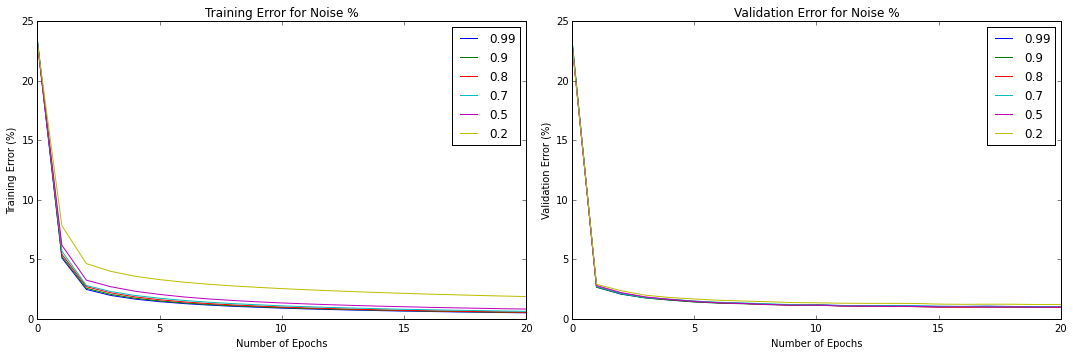

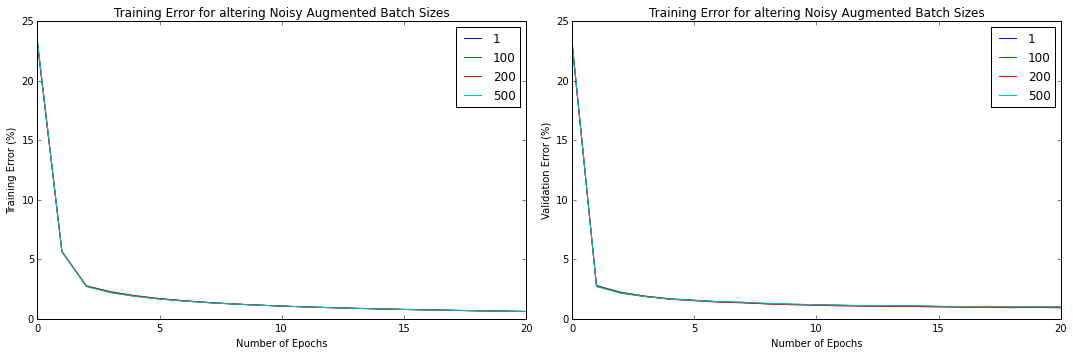

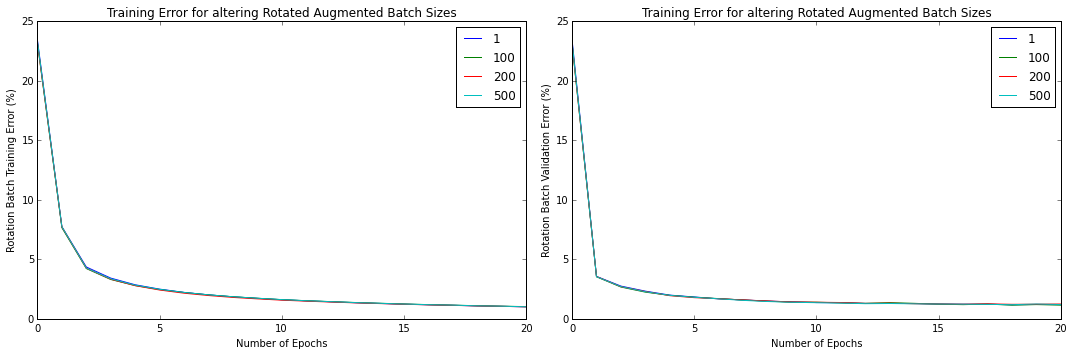

In [8]:
"""
Draw Testing & Validation Errors for tests on varying batch size and noise percentage on my augmenter. 
"""

%matplotlib inline

logger.warning("Drawing Graphs...")
counter = 0
plt.figure(figsize=(15, 5))
for result in noise_stats:

#     logger.warning("Drawing Tests for {0}".format(augmented_percentages[counter]))
    counter_label = 0
    
    (tr_stats, valid_stats, (tst_cost, tst_accuracy)) = result 
    train_accuracies = []
    for stat in tr_stats:
        train_accuracies.append(stat[0]*10)

    validation_accuracies = []
    for stat in valid_stats:
        validation_accuracies.append(stat[0]*10)

    plt.subplot(1,2,1)
    plt.plot(train_accuracies, label=augmented_percentages[counter])
    plt.title("Training Error for Noise %")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Training Error (%)")
    plt.legend()
    plt.grid()
    plt.tight_layout()

    plt.subplot(1,2,2)
    plt.plot(validation_accuracies, label=augmented_percentages[counter])
    plt.title("Validation Error for Noise %")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Validation Error (%)")
    plt.legend()
    plt.grid()
    plt.tight_layout()

    counter += 1
    
plt.show()

counter = 0
plt.figure(figsize=(15, 5))
for result in batch_stats:

#     logger.warning("Drawing Tests {0}".format(augmented_number_of_batches[counter]))
    counter_label = 0
    
    (tr_stats, valid_stats, (tst_cost, tst_accuracy)) = result 
    train_accuracies = []
    for stat in tr_stats:
        train_accuracies.append(stat[0]*10)

    validation_accuracies = []
    for stat in valid_stats:
        validation_accuracies.append(stat[0]*10)

    plt.subplot(1,2,1)
    plt.plot(train_accuracies, label=augmented_number_of_batches[counter])
    plt.title("Training Error for altering Noisy Augmented Batch Sizes")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Training Error (%)")
    plt.legend()
    plt.grid()
    plt.tight_layout()

    plt.subplot(1,2,2)
    plt.plot(validation_accuracies, label=augmented_number_of_batches[counter])
    plt.title("Training Error for altering Noisy Augmented Batch Sizes")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Validation Error (%)")
    plt.legend()
    plt.grid()
    plt.tight_layout()

    counter += 1
    
plt.show()

counter = 0
plt.figure(figsize=(15, 5))
for result in rotation_batch_stats:

#     logger.warning("Drawing Tests {0}".format(rotation_augmented_number_of_batches[counter]))
    counter_label = 0
    
    (tr_stats, valid_stats, (tst_cost, tst_accuracy)) = result 
    train_accuracies = []
    for stat in tr_stats:
        train_accuracies.append(stat[0]*10)

    validation_accuracies = []
    for stat in valid_stats:
        validation_accuracies.append(stat[0]*10)

    plt.subplot(1,2,1)
    plt.plot(train_accuracies, label=rotation_augmented_number_of_batches[counter])
    plt.title("Training Error for altering Rotated Augmented Batch Sizes")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Rotation Batch Training Error (%)")
    plt.legend()
    plt.grid()
    plt.tight_layout()

    plt.subplot(1,2,2)
    plt.plot(validation_accuracies, label=rotation_augmented_number_of_batches[counter])
    plt.title("Training Error for altering Rotated Augmented Batch Sizes")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Rotation Batch Validation Error (%)")
    plt.legend()
    plt.grid()
    plt.tight_layout()

    counter += 1
    
plt.show()


In [ ]:
"""
Comments on graphs: 
The noise percentages here get a better accuracy, the higher they are (should be noted that the percentage is infact
1-val), the better the accuracy. 

We don't see any immediate difference given the larger training sets on both the noise and rotated batches. 
The gain here seems to be with the training set performance. It slows the model 
from overfitting, allowing it to run more epochs, continuously improving, thus 
allowing the accuracy of the validation set to increase for longer. 
"""

### Task 5 - State of the art (5 marks)

Using any techniques you have learnt so far (combining any number of them), build and train the best model you can (no other constraints).

In [33]:
"""
The Model and layer size were initially derived from my solution in the previous coursework. 
A 4 layer network with 2 hidden layers was what gave me the greatest accuracy, so I decided to 
start with that.

My L1 and L2 values were taken from my model which experimented with both. A weight of 0.0001
for both respective values gave me the best increase in accuracy overall. This was also apparent
on experiments which only varied 1 value of the two.

The Dropout Scheduler was selected again based on which ratio resulted in the best test set accuracy
and with respect to max_epochs.

A lot of my models was overfitting to the training set, giving validation accuracies of >99%. 

I then implemented my Augmented training set, adding noise of 20%, the value which 
gave the largest increase in accuracy in test 4. 

My cross entropy optimiser gave me the best result and was thus included in this models, using the parameters
that achieved that result. 

Seeing that the training accuracy was around 99%, I attempted to add more epochs, having more simply resulted
in a smaller accuracy.

My best result is what is seen below. Results from a few of my previous experiements may also be seen under that.
""" 
logger.setLevel(logging.INFO)

nhid = 73
max_epochs = 50
l1_weight = 0.0001
l2_weight = 0.0001
cost = CECost()
layer = 4
train_dp.reset()
valid_dp.reset()
test_dp.reset()

logger.warning("Setting up Augmented_dp for {0}% DropOutNoise".format(0.8))
augmented_dp = MNISTDataProvider(dset='train', batch_size=100, max_num_batches=-10, randomize=True)
augmentation = DropOutNoise(0.8,rng)
Augmenter(dataset=augmented_dp, number_of_batches=200, augmentation=augmentation).get_new_batch()

model = MLP(cost=cost)

model.add_layer(Sigmoid(idim=784, odim=398, rng=rng))
model.add_layer(Sigmoid(idim=398, odim=398, rng=rng))
model.add_layer(Sigmoid(idim=398, odim=398, rng=rng))
model.add_layer(Softmax(idim=398, odim=10, rng=rng))

optimiser = CrossEntropyOptimiser(learning_rate=0.5, 
                                      max_epochs=20,
                                     dp_scheduler=None,
                                     l1_weight=l1_weight, 
                                     l2_weight=l2_weight)

optimiser.pre_train(model, train_dp, valid_dp)


lr_scheduler = LearningRateExponential(learning_rate=2.0, max_epochs=max_epochs, r=10.0)

dp_scheduler = DropoutAnnealing(0.5, 0.5, 0.01)

optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, 
                         dp_scheduler=dp_scheduler,
                         l1_weight=l1_weight, 
                         l2_weight=l2_weight)

logger.warning('Training started...')

start_time = time.clock()
tr_stats, valid_stats = optimiser.train(model, augmented_dp, valid_dp)    
end_time = time.clock()

logger.warning('Time taken to train: {0}'.format(end_time - start_time))

logger.warning('Testing the model on test set:')
tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
logger.warning('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))
    
logger.warning('Model Testing Complete.')

INFO:mlp.optimisers:Pre train model i=0
INFO:mlp.optimisers:Pre train model j=0
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 4.033. Accuracy is 13.63%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 2.361. Accuracy is 83.99%
INFO:mlp.optimisers:Epoch 1
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 2.060. Accuracy is 91.08%
INFO:mlp.optimisers:Epoch 2
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 2.039. Accuracy is 92.64%
INFO:mlp.optimisers:Epoch 3
INFO:mlp.optimisers:Epoch 4: Training cost (ce) is 2.028. Accuracy is 93.67%
INFO:mlp.optimisers:Epoch 4
INFO:mlp.optimisers:Epoch 5: Training cost (ce) is 2.022. Accuracy is 94.62%
INFO:mlp.optimisers:Epoch 5
INFO:mlp.optimisers:Epoch 6: Training cost (ce) is 2.021. Accuracy is 95.23%
INFO:mlp.optimisers:Epoch 6
INFO:mlp.optimisers:Epoch 7: Training cost (ce) is 2.023. Accuracy is 95.72%
INFO:mlp.optimisers:Epoch 7
INFO:mlp.optimisers:Epoch 8: Training cost (ce) is 2.026. Accuracy is 96.25%
INFO:mlp.opti

In [ ]:
"""
Other Experiments & accuracies

4 Layers
96.4 = with dropout annealing
97.82 = no dropout annealing, noisy data added to set
97.17 = dropout annealing, noisy data added to set and 30 epochs
97.88 = cross entropy 30 epochs 
98.25 = 50 Epochs

2 Layers 
96.49 = dropout annealing
97.18 = no dropout annealing
97.40 = with noisy data added to set
97.26 = 50 epochs


"""

# Part 2. Convolutional Neural Networks (55 marks)

In this part of the coursework, you are required to implement deep convolutional networks.  This includes code for forward prop, back prop, and weight updates for convolutional and max-pooling layers, and should support the stacking of convolutional + pooling layers.  You should implement all the parts relating to the convolutional layer in the mlp/conv.py module; if you decide to implement some routines in cython, keep them in mlp/conv.pyx). Attach both files in this notebook.

Implementation tips: Look at [lecture 7](http://www.inf.ed.ac.uk/teaching/courses/mlp/2015/mlp07-cnn.pdf) and [lecture 8](http://www.inf.ed.ac.uk/teaching/courses/mlp/2015/mlp08-cnn2.pdf), and the introductory tutorial, [06_MLP_Coursework2_Introduction.ipynb](https://github.com/CSTR-Edinburgh/mlpractical/blob/master/06_MLP_Coursework2_Introduction.ipynb)

### Task 6 -  Implement convolutional layer (20 marks)

Implement linear convolutional layer, and then extend to sigmoid and ReLU transfer functions (do it in a similar way to fully-connected layers). Include all relevant code.  It is recommended that you first implement in the naive way with nested loops (python and/or cython);  optionally you may then implement in a vectorised way in numpy.  Include logs for each way you implement the convolutional layer, as timings for different implementations are of interest.  Include all relevant code.

In [ ]:
class ConvLinear(Layer):
    def __init__(self,
                 num_inp_feat_maps,
                 num_out_feat_maps,
                 image_shape=(28, 28),
                 kernel_shape=(5, 5),
                 stride=(1, 1),
                 irange=0.2,
                 rng=None,
                 conv_fwd=my1_conv2d,
                 conv_bck=my1_conv2d,
                 conv_grad=my1_conv2d):
        """

        :param num_inp_feat_maps: int, a number of input feature maps (channels)
        :param num_out_feat_maps: int, a number of output feature maps (channels)
        :param image_shape: tuple, a shape of the image
        :param kernel_shape: tuple, a shape of the kernel
        :param stride: tuple, shift of kernels in both dimensions
        :param irange: float, initial range of the parameters
        :param rng: RandomState object, random number generator
        :param conv_fwd: handle to a convolution function used in fwd-prop
        :param conv_bck: handle to a convolution function used in backward-prop
        :param conv_grad: handle to a convolution function used in pgrads
        :return:
        """

        super(ConvLinear, self).__init__(rng=rng)

        self.num_inp_feat_maps = num_inp_feat_maps
        self.num_out_feat_maps = num_out_feat_maps
        self.image_shape = image_shape
        self.kernel_shape = kernel_shape
        self.stride = stride
        self.conv_fwd = conv_fwd
        self.conv_bck = conv_bck
        self.conv_grad = conv_grad


        # initialising feature maps weights and biases

        image_width, image_height = self.image_shape
        k_width, k_height = self.kernel_shape

        self.number_of_unit_rows = image_width - k_width + 1
        self.number_of_unit_cols = image_height - k_height + 1

        self.W = numpy.array(self.rng.uniform(-irange, irange,
                                              (num_inp_feat_maps,
                                               num_out_feat_maps,
                                               k_width,
                                               k_height)))

        self.b = numpy.zeros((
                                 num_out_feat_maps
                             ),
                             dtype=numpy.float32)


    def fprop(self, inputs):
        inputs = inputs.reshape((inputs.shape[0],
                                 self.num_inp_feat_maps,
                                 self.image_shape[0],
                                 self.image_shape[1]))

        outputs = numpy.zeros((inputs.shape[0],
                               self.num_out_feat_maps,
                               self.number_of_unit_rows,
                               self.number_of_unit_cols),
                              dtype=numpy.float32)

        for row_u in xrange(0, self.number_of_unit_rows):
            for col_v in xrange(0, self.number_of_unit_cols):
                for f in xrange(0, self.num_out_feat_maps):
                    for image_i in xrange(inputs.shape[0]):
                        for ifm in xrange(0, inputs.shape[1]):
                            w = self.W[ifm][f]
                            i = inputs[image_i][ifm][row_u: self.kernel_shape[0] + row_u,
                                col_v:self.kernel_shape[1] + col_v]
                            sum_along_b = numpy.sum((i * w).reshape(-1))

                            outputs[image_i][f][row_u][col_v] += sum_along_b
                        outputs[image_i][f][row_u][col_v] += self.b[f]

        return outputs


    def bprop(self, h, igrads):
        igrads = igrads.reshape(
            (igrads.shape[0], self.num_out_feat_maps, self.number_of_unit_rows, self.number_of_unit_cols))

        outputs = numpy.zeros((igrads.shape[0],
                               self.num_inp_feat_maps,
                               self.image_shape[0],
                               self.image_shape[1]), dtype=numpy.float32)
        deltas = igrads.T

        for row_u in xrange(0, self.number_of_unit_rows):
            for col_u in xrange(0, self.number_of_unit_cols):
                for ifm in xrange(0, self.num_inp_feat_maps):
                    for f in xrange(0, self.num_out_feat_maps):
                        for image_i in xrange(outputs.shape[0]):
                            d = deltas[col_u][row_u][f][image_i]
                            a = self.W[ifm][f] * d
                            outputs[image_i][ifm][row_u:self.kernel_shape[0] + row_u,
                            col_u:self.kernel_shape[1] + col_u] += a

        return igrads, outputs.reshape(outputs.shape[0], -1)

    def bprop_cost(self, h, igrads, cost):
        raise NotImplementedError('ConvLinear.bprop_cost method not implemented')

    def pgrads(self, inputs, deltas, l1_weight=0, l2_weight=0):
        inputs = inputs.reshape((inputs.shape[0],
                                 self.num_inp_feat_maps,
                                 self.image_shape[0],
                                 self.image_shape[1]))
        deltas = deltas.reshape(deltas.shape[0],
                                self.num_out_feat_maps,
                                self.number_of_unit_rows,
                                self.number_of_unit_cols)
        grad_W = numpy.zeros(self.W.shape, dtype=numpy.float32)

        for row_u in xrange(0, self.number_of_unit_rows):
            for col_u in xrange(0, self.number_of_unit_cols):
                for ifm in xrange(0, self.num_inp_feat_maps):
                    for f in xrange(0, self.num_out_feat_maps):
                        for image_i in xrange(inputs.shape[0]):
                            grad = inputs[image_i][ifm][row_u:self.kernel_shape[0] + row_u,
                                   col_u:self.kernel_shape[1] + col_u] * deltas[image_i][f][row_u][col_u]
                            grad_W[ifm][f] += grad

        grad_b = numpy.sum(numpy.sum(deltas.reshape(deltas.shape[0], deltas.shape[1], -1), axis=0), axis=1)
        return [grad_W, grad_b]

    def get_params(self):
        return [self.W, self.b]

    def set_params(self, params):
        # we do not make checks here, but the order on the list
        #is assumed to be exactly the same as get_params() returns
        self.W = params[0]
        self.b = params[1]

    def get_name(self):
        return 'convlinear'


class ConvSigmoid(ConvLinear):
    def fprop(self, inputs):
        # get the linear activations
        a = super(ConvSigmoid, self).fprop(inputs)
        # stabilise the exp() computation in case some values in
        # 'a' get very negative.
        numpy.clip(a, -30.0, 30.0, out=a)
        h = 1.0 / (1 + numpy.exp(-a))
        return h

    def bprop(self, h, igrads):
        a = h.reshape(igrads.shape)
        dsigm = a * (1.0 - a)
        deltas = igrads * dsigm
        ___, ograds = super(ConvSigmoid, self).bprop(h=None, igrads=deltas)
        return deltas, ograds

    def bprop_cost(self, h, igrads, cost):
        if cost is None or cost.get_name() == 'bce':
            return super(ConvSigmoid, self).bprop(h=h, igrads=igrads)
        else:
            raise NotImplementedError('Sigmoid.bprop_cost method not implemented '
                                      'for the %s cost' % cost.get_name())

    def get_name(self):
        return 'convsigmoid'


class ConvRelu(ConvLinear):
    def fprop(self, inputs):
        # get the linear activations
        a = super(ConvRelu, self).fprop(inputs)
        h = numpy.clip(a, 0, 20.0)
        # h = numpy.maximum(a, 0)
        return h

    def bprop(self, h, igrads):
        h = h.reshape(igrads.shape)
        deltas = (h > 0) * igrads
        ___, ograds = super(ConvRelu, self).bprop(h=None, igrads=deltas)
        return deltas, ograds

    def bprop_cost(self, h, igrads, cost):
        raise NotImplementedError('Relu.bprop_cost method not implemented for the %s cost' % cost.get_name())

    def get_name(self):
        return 'convrelu'


### Task 7 - Implement max-pooling layer (10 marks)

Implement a max-pooling layer. Non-overlapping pooling (which was assumed in the lecture presentation) is required. You may also implement a more generic solution with striding as well. Include all relevant code.

In [ ]:
class ConvMaxPool2D(Layer):
    def __init__(self,
                 num_feat_maps,
                 conv_shape,
                 pool_shape=(2, 2),
                 pool_stride=(2, 2)):
        """

        :param conv_shape: tuple, a shape of the lower convolutional feature maps output
        :param pool_shape: tuple, a shape of pooling operator
        :param pool_stride: tuple, a strides for pooling operator
        :return:
        """

        super(ConvMaxPool2D, self).__init__(rng=None)
        self.pool_stride = pool_stride
        self.pool_shape = pool_shape
        self.conv_shape = conv_shape
        self.num_feat_maps = num_feat_maps
        self.number_of_unit_rows = self.conv_shape[0]/2
        self.number_of_unit_cols = self.conv_shape[1]/2
        self.W = None

    def fprop(self, inputs):
        self.W = numpy.zeros((
            inputs.shape[0],
            self.num_feat_maps,
            self.number_of_unit_rows,
            self.number_of_unit_cols,
            self.pool_shape[0],
            self.pool_shape[1]
        ), dtype=numpy.float32)

        outputs = numpy.zeros(
            (inputs.shape[0],
             self.num_feat_maps,
             self.number_of_unit_rows,
             self.number_of_unit_cols), dtype=numpy.float32)

        for row_u in xrange(0, self.number_of_unit_rows):
            for col_u in xrange(0, self.number_of_unit_cols):
                for f in xrange(0, self.num_feat_maps):
                    for image_i in xrange(inputs.shape[0]):
                        sub_inputs = inputs[image_i][f][row_u * self.pool_shape[0]: (1 + row_u) * self.pool_shape[0], col_u * self.pool_shape[1]:(1 + col_u) * self.pool_shape[1]]
                        index_max = numpy.argmax(sub_inputs, axis=0)
                        outputs[image_i][f][row_u][col_u] = numpy.max(sub_inputs)
                        self.W[image_i][f][row_u][col_u][index_max[0]][index_max[1]] = 1
        return outputs


    def bprop(self, h, igrads):
        igrads = igrads.reshape(
            (igrads.shape[0], self.num_feat_maps, self.number_of_unit_rows, self.number_of_unit_cols))

        outputs = numpy.zeros((igrads.shape[0],
                               self.num_feat_maps,
                               self.conv_shape[0],
                               self.conv_shape[1]), dtype=numpy.float32)
        deltas = igrads.T

        for row_u in xrange(0, self.number_of_unit_rows):
            for col_u in xrange(0, self.number_of_unit_cols):
                for f in xrange(0, self.num_feat_maps):
                    for image_i in xrange(outputs.shape[0]):
                        d = deltas[col_u][row_u][f][image_i]
                        a = self.W[image_i][f][row_u][col_u] * d
                        outputs[image_i][f][row_u * self.pool_shape[0]: (1 + row_u) * self.pool_shape[0], col_u * self.pool_shape[1]:(1 + col_u) * self.pool_shape[1]] += a

        return igrads, outputs.reshape(outputs.shape[0], -1)

    def get_params(self):
        return []

    def pgrads(self, inputs, deltas, **kwargs):
        return []

    def set_params(self, params):
        pass

    def get_name(self):
        return 'convmaxpool2d'

### Task 8 - Experiments with convolutional networks (25 marks)

Construct convolutional networks with a softmax output layer and a single fully connected hidden layer. Your first experiments should use one convolutional+pooling layer.  As a default use convolutional kernels of dimension 5x5 (stride 1) and pooling regions of 2x2 (stride 2, hence non-overlapping).

*  Implement and test a convolutional network with 1 feature map
*  Implement and test a convolutional network with 5 feature maps

Explore convolutional networks with two convolutional layers, by implementing, training, and evaluating a network with two convolutional+maxpooling layers with 5 feature maps in the first convolutional layer,  and 10 feature maps in the second convolutional layer.

Carry out further experiments to optimise the convolutional network architecture (you could explore kernel sizes and strides, number of feature maps, sizes and strides of pooling operator, etc. - it is up to you).

In [7]:
"""
Conv_sigmoid with 1 feature_map
""" 
logger.setLevel(logging.INFO)

max_epochs = 5

cost = CECost()

logger.warning('Building data sets...')
train_dp = MNISTDataProvider(dset='train', batch_size=100, max_num_batches=100, randomize=True)
valid_dp = MNISTDataProvider(dset='valid', batch_size=100, max_num_batches=100, randomize=False)
test_dp = MNISTDataProvider(dset='eval', batch_size=100, max_num_batches=100, randomize=False)

train_dp.reset()
valid_dp.reset()
test_dp.reset()

model = MLP(cost=cost)

model.add_layer(ConvSigmoid(1, 1, image_shape=(28, 28), kernel_shape=(5, 5), stride=(1, 1),irange=0.2))
model.add_layer(ConvMaxPool2D(num_feat_maps=1, conv_shape=(24, 24), pool_shape=(2, 2)))
model.add_layer(Sigmoid(idim=144, odim=100, rng=rng))
model.add_layer(Softmax(idim=100, odim=10, rng=rng))

lr_scheduler = LearningRateFixed(learning_rate=0.5, max_epochs=max_epochs)

optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, 
                         dp_scheduler=None,
                         l1_weight=0.0, 
                         l2_weight=0.0)

logger.warning('Training started...')

start_time = time.clock()
tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)    
end_time = time.clock()

logger.warning('Time taken to train: {0}'.format(end_time - start_time))

logger.warning('Testing the model on test set:')
tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
logger.warning('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))
    
logger.warning('Model Testing Complete.')

INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 2.352. Accuracy is 9.79%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for initial model is 2.346. Accuracy is 10.30%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 2.338. Accuracy is 10.64%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 2.304. Accuracy is 10.64%
INFO:mlp.optimisers:Epoch 1: Took 378 seconds. Training speed 42 pps. Validation speed 72 pps.
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 2.143. Accuracy is 26.41%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 1.617. Accuracy is 62.50%
INFO:mlp.optimisers:Epoch 2: Took 371 seconds. Training speed 43 pps. Validation speed 72 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 1.029. Accuracy is 71.96%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 0.618. Accuracy is 83.81%
INFO:mlp.optimisers:Epoch 3: Took 380 seconds. Training speed 42 pps. Validation speed 71 pps.
INFO:mlp.optimisers:Epoch 4: Training cost (ce) is 0.569

In [9]:
"""
Conv_sigmoid with 5 feature_map
""" 
logger.setLevel(logging.INFO)

max_epochs = 5

cost = CECost()

logger.warning('Building data sets...')
train_dp = MNISTDataProvider(dset='train', batch_size=100, max_num_batches=100, randomize=True)
valid_dp = MNISTDataProvider(dset='valid', batch_size=100, max_num_batches=100, randomize=False)
test_dp = MNISTDataProvider(dset='eval', batch_size=100, max_num_batches=100, randomize=False)

train_dp.reset()
valid_dp.reset()
test_dp.reset()

model = MLP(cost=cost)

model.add_layer(ConvSigmoid(1, 5, image_shape=(28, 28), kernel_shape=(5, 5), stride=(1, 1),irange=0.2))
model.add_layer(ConvMaxPool2D(num_feat_maps=5, conv_shape=(24, 24), pool_shape=(2, 2)))
model.add_layer(Sigmoid(idim=720, odim=100, rng=rng))
model.add_layer(Softmax(idim=100, odim=10, rng=rng))

lr_scheduler = LearningRateFixed(learning_rate=0.5, max_epochs=max_epochs)

optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, 
                         dp_scheduler=None,
                         l1_weight=0.0, 
                         l2_weight=0.0)

logger.warning('Training started...')

start_time = time.clock()
tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)    
end_time = time.clock()

logger.warning('Time taken to train: {0}'.format(end_time - start_time))

logger.warning('Testing the model on test set:')
tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
logger.warning('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))
    
logger.warning('Model Testing Complete.')

INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 2.406. Accuracy is 14.10%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for initial model is 2.417. Accuracy is 13.76%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 2.185. Accuracy is 21.55%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 1.520. Accuracy is 58.72%
INFO:mlp.optimisers:Epoch 1: Took 1906 seconds. Training speed 8 pps. Validation speed 15 pps.
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 0.950. Accuracy is 70.40%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 0.753. Accuracy is 77.00%
INFO:mlp.optimisers:Epoch 2: Took 1912 seconds. Training speed 8 pps. Validation speed 14 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 0.498. Accuracy is 84.40%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 0.375. Accuracy is 89.35%
INFO:mlp.optimisers:Epoch 3: Took 1908 seconds. Training speed 8 pps. Validation speed 15 pps.
INFO:mlp.optimisers:Epoch 4: Training cost (ce) is 0.39

In [8]:
"""
2 conv + max pooling layers with 5 feature maps in first layer and 10 in second.
""" 
logger.setLevel(logging.INFO)

max_epochs = 5

cost = CECost()

logger.warning('Building data sets...')
train_dp = MNISTDataProvider(dset='train', batch_size=100, max_num_batches=100, randomize=True)
valid_dp = MNISTDataProvider(dset='valid', batch_size=100, max_num_batches=100, randomize=False)
test_dp = MNISTDataProvider(dset='eval', batch_size=100, max_num_batches=100, randomize=False)

train_dp.reset()
valid_dp.reset()
test_dp.reset()

model = MLP(cost=cost)

model.add_layer(ConvSigmoid(1, 5, image_shape=(28, 28), kernel_shape=(5, 5), stride=(1, 1),irange=0.2))
model.add_layer(ConvMaxPool2D(num_feat_maps=5, conv_shape=(24, 24), pool_shape=(2, 2)))
model.add_layer(ConvSigmoid(5, 10, image_shape=(12, 12), kernel_shape=(5, 5), stride=(1, 1),irange=0.2))
model.add_layer(ConvMaxPool2D(num_feat_maps=10, conv_shape=(8, 8), pool_shape=(2, 2)))
model.add_layer(Sigmoid(idim=160, odim=50, rng=rng))
model.add_layer(Softmax(idim=50, odim=10, rng=rng))

lr_scheduler = LearningRateFixed(learning_rate=0.5, max_epochs=max_epochs)

optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, 
                         dp_scheduler=None,
                         l1_weight=0.0, 
                         l2_weight=0.0)

logger.warning('Training started...')

start_time = time.clock()
tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)    
end_time = time.clock()

logger.warning('Time taken to train: {0}'.format(end_time - start_time))

logger.warning('Testing the model on test set:')
tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
logger.warning('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))
    
logger.warning('Model Testing Complete.')

INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 2.320. Accuracy is 9.03%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for initial model is 2.323. Accuracy is 9.15%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 2.320. Accuracy is 10.39%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 2.309. Accuracy is 10.64%
INFO:mlp.optimisers:Epoch 1: Took 3611 seconds. Training speed 4 pps. Validation speed 8 pps.
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 2.307. Accuracy is 10.51%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 2.303. Accuracy is 10.90%
INFO:mlp.optimisers:Epoch 2: Took 3650 seconds. Training speed 4 pps. Validation speed 8 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 2.303. Accuracy is 10.99%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 2.301. Accuracy is 10.90%
INFO:mlp.optimisers:Epoch 3: Took 3691 seconds. Training speed 4 pps. Validation speed 8 pps.
INFO:mlp.optimisers:Epoch 4: Training cost (ce) is 2.301. Ac

In [ ]:
"""
My implementation was naive, using for loops. I didn't have time to translate it into vectorised numpy or cython. 
This naive implementation was thus too slow to run any experiements such as comparing different numbers of feature maps
other than the ones above.

In at least running my implementation on low max epochs and batch sizes, I can see the relative difference in the 
test accuracies between the first two above convolution models. 

My third model unfortunately lacks a high accuracy. I believe
this is due to the low number of epochs and the small amount of training data.
I imagine it would increase with more epochs due to the sudden accuracy increase at the end.

Thank you for the last 14 weeks! I've learned a lot. 
"""

**This is the end of coursework 2.**

Please remember to save your notebook, and submit your notebook following the instructions at the top.  Please make sure that you have executed all the code cells when you submit the notebook.
